In [ ]:
from IPython.display import clear_output
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle competitions download -c geekbrains-competitive-data-analysis
!unzip geekbrains-competitive-data-analysis.zip
!rm geekbrains-competitive-data-analysis.zip
clear_output()

!pip install -qq BorutaShap catboost optuna 
!pip install -qq category_encoders

import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Optional, List, Tuple
from pprint import pprint
from tqdm import tqdm
import time
import re
from scipy import stats

import missingno as msno
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, MinMaxScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.base import clone
from sklearn.decomposition import PCA

from BorutaShap import BorutaShap
import category_encoders as ce

from lightgbm import LGBMClassifier
import optuna
from optuna.samplers import TPESampler

import gc
gc.enable()

     |████████████████████████████████| 76.6 MB 1.3 MB/s 
     |████████████████████████████████| 348 kB 55.1 MB/s 
     |████████████████████████████████| 569 kB 52.2 MB/s 
     |████████████████████████████████| 209 kB 45.5 MB/s 
     |████████████████████████████████| 81 kB 7.9 MB/s 
     |████████████████████████████████| 78 kB 7.4 MB/s 
     |████████████████████████████████| 49 kB 5.6 MB/s 
     |████████████████████████████████| 147 kB 49.1 MB/s 
     |████████████████████████████████| 112 kB 46.5 MB/s 
     |████████████████████████████████| 69 kB 3.3 MB/s 


In [ ]:
seed = 42
np.random.seed(seed)
np.set_printoptions(2)
pd.options.display.float_format = '{:.4f}'.format
plt.style.use('ggplot')
pd.set_option('display.max_columns', None)

ID_COL = 'APPLICATION_NUMBER'
TARGET= 'TARGET'

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
cp = pd.read_csv('client_profile.csv')
payments = pd.read_csv('payments.csv')
history = pd.read_csv('applications_history.csv')
bki = pd.read_csv('bki.csv')

In [ ]:
bki.duplicated().sum()

0

In [ ]:
for column in bki.columns:
    if bki[column].nunique() < 2:
        print(column)

In [ ]:
train[TARGET].value_counts(normalize=True)

0   0.9192
1   0.0808
Name: TARGET, dtype: float64

In [ ]:
def check_missings(df: pd.DataFrame) -> pd.DataFrame:
    na = df.isnull().sum()
    result = pd.DataFrame({
        "Total": na,
        "Percent": 100*na/df.shape[0],
        "Types": df.dtypes
    })
    result = result[result["Total"] != 0]
    print(f"Total NA-values = {na.sum()}")
    return result.T

def create_numerical_aggs(data: pd.DataFrame,
                          groupby_id: str,
                          aggs: dict,
                          prefix: Optional[str] = None,
                          suffix: Optional[str] = None,
                          ) -> pd.DataFrame:    
    if not prefix:
        prefix = ""
    if not suffix:
        suffix = ""

    data_grouped = data.groupby(groupby_id)
    stats = data_grouped.agg(aggs)
    stats.columns = [f"{prefix}{feature}_{stat}{suffix}".upper() for feature, stat in stats]
    stats = stats.reset_index()

    return stats

def create_categorical_aggs(data: pd.DataFrame,
                            groupby_id: str,
                            features: List[str],
                            prefix: Optional[str] = None,
                            suffix: Optional[str] = None,
                            ) -> pd.DataFrame:
    if not prefix:
        prefix = ""
    if not suffix:
        suffix = ""

    categorical = pd.get_dummies(data[features])
    columns_to_agg = categorical.columns

    categorical[groupby_id] = data[groupby_id]
    data_grouped = categorical.groupby(groupby_id)
    stats = data_grouped.agg({col: ["mean", "sum"] for col in columns_to_agg})
    stats.columns = [f"{prefix}{feature}_{stat}{suffix}".upper() for feature, stat in stats]
    stats.columns = [col.replace("MEAN", "RATIO") for col in stats.columns]
    stats.columns = [col.replace("SUM", "TOTAL") for col in stats.columns]
    stats = stats.reset_index()

    return stats

def calculate_feature_separating_ability(
    features: pd.DataFrame, target: pd.Series, fill_value: float = -9999) -> pd.DataFrame:

    scores = {}
    for feature in features:
        score = roc_auc_score(
            target, features[feature].fillna(fill_value)
        )
        scores[feature] = 2*score - 1

    scores = pd.Series(scores)
    scores = scores.sort_values(ascending=False)

    return scores

def _predict(estimator, x_valid, probas=True):
    if hasattr(estimator, "predict_proba") and probas:
        y_pred = estimator.predict_proba(x_valid)[:, 1]
    else:
        y_pred = estimator.predict(x_valid)

    return y_pred

def calculate_permutation_importance(estimator,
                                     metric: callable,
                                     x_valid: pd.DataFrame,
                                     y_valid: pd.DataFrame,
                                     maximize: bool = True,
                                     probas: bool = False
                                     ) -> pd.Series:
    y_pred = _predict(estimator, x_valid, probas)
    base_score = metric(y_valid, y_pred)
    scores, delta = {}, {}

    for feature in tqdm(x_valid.columns):
        x_valid_ = x_valid.copy(deep=True)
        np.random.seed(seed)
        x_valid_[feature] = np.random.permutation(x_valid_[feature])

        y_pred = _predict(estimator, x_valid_, probas)
        feature_score = metric(y_valid, y_pred)

        if maximize:
            delta[feature] = base_score - feature_score
        else:
            delta[feature] = feature_score - base_score

        scores[feature] = feature_score

    scores, delta = pd.Series(scores), pd.Series(delta)
    scores = scores.sort_values(ascending=False)
    delta = delta.sort_values(ascending=False)

    return scores, delta

def make_modify_cross_validation(X: pd.DataFrame,
                                 y: pd.Series,
                                 estimator: object,
                                 metric: callable,
                                 cv_strategy,
                                 error_to_be_outlier: None,
                                 verbose: bool = True,
                                 proba: bool = True,
                                 early: bool = False):

    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        
        if early:
            estimator.fit(x_train, y_train, 
                          eval_metric="auc",
                          eval_set=[(x_train, y_train), (x_valid, y_valid)], 
                          early_stopping_rounds=early,
                          verbose=-1)
        else:
            estimator.fit(x_train, y_train)
        if proba:
            y_train_pred = estimator.predict_proba(x_train)[:,1]
            y_valid_pred = estimator.predict_proba(x_valid)[:,1]
        else:
            y_train_pred = estimator.predict(x_train)
            y_valid_pred = estimator.predict(x_valid)

        fold_train_scores.append(metric(y_train, y_train_pred))
        if not error_to_be_outlier:
            fold_valid_scores.append(metric(y_valid, y_valid_pred))
        else:
            # mask = ((y_valid - y_valid_pred) / y_valid) < error_to_be_outlier  # for regression task: 0.05
            y_valid_pred = pd.Series(data=y_valid_pred, index=y_valid.index, name='predictions')
            outliers = iso.predict(x_valid.select_dtypes(include="number"))
            mask = y_valid[outliers == 1].index
            fold_valid_scores.append(metric(y_valid.loc[mask], y_valid_pred.loc[mask]))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        if verbose:
            print(msg)
            print("="*69)
        if hasattr(estimator, "copy"):
            est = estimator.copy()
            estimators.append(est)
        else:
            estimators.append(estimator)

    if not error_to_be_outlier:
        oof_score = metric(y, oof_predictions)
    else:
        # mask = ((y - oof_predictions) / y) < error_to_be_outlier  # for regression task
        oof_predictions = pd.Series(data=oof_predictions, index=y.index, name="oof_predictions")
        outliers = iso.predict(X.select_dtypes(include="number"))
        mask = y[outliers == 1].index
        oof_score = metric(y.loc[mask], oof_predictions.loc[mask])

    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

def reduce_memory_df(df):
    """Reduce memory usage by converting data to more appropriate dtypes"""
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and str(col_type)[:4] != 'uint' and str(col_type) != 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif str(col_type)[:4] != 'uint':
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

def mean_scores(scores, target):
    scores_list = [
        (scores.mean(axis=1), 'AMean score: '),
        (stats.gmean(scores, axis=1), 'GMean score: '),
        (scores.rank().mean(axis=1), 'Rank  score: '),
        (stats.gmean(scores.rank(), axis=1), 'GMean  rank: ')
    ]

    for scores_mean in scores_list:
        score = roc_auc_score(target, scores_mean[0])
        print(f"{scores_mean[1]}{score:.5f}")

In [ ]:
train_ids = set(train[ID_COL])
test_ids = set(test[ID_COL])

hist_ids = set(history[ID_COL])
bki_ids = set(bki[ID_COL])
pay_ids = set(payments[ID_COL])
cp_ids = set(cp[ID_COL])

### Profile

In [ ]:
cp.describe()

,APPLICATION_NUMBER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
count,250000.0000,250000.0000,250000.0000,250000.0000,249989.0000,250000.0000,250000.0000,250000.0000,85041.0000,250000.0000,250000.0000,249998.0000,109121.0000,249468.0000,200462.0000,216293.0000,216293.0000,216293.0000,216293.0000,216293.0000,216293.0000
mean,123577106.0131,0.4176,169066.1513,599305.1255,27125.2096,0.0209,16033.4605,67505.8833,12.0302,0.2802,0.0571,2.1540,0.5021,0.5142,0.5108,0.0063,0.0069,0.0342,0.2675,0.2668,1.8990
std,88777.2224,0.7225,258847.9858,402272.0241,14503.9304,0.0138,4361.3323,139261.0996,11.8994,0.4491,0.2320,0.9115,0.2108,0.1911,0.1951,0.0838,0.1080,0.2040,0.9145,0.8315,1.8688
min,123423341.0000,0.0000,25650.0000,45000.0000,1615.5000,0.0003,7489.0000,0.0000,0.0000,0.0000,0.0000,1.0000,0.0147,0.0000,0.0005,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
25%,123500214.5000,0.0000,112500.0000,270000.0000,16524.0000,0.0100,12415.0000,931.0000,5.0000,0.0000,0.0000,2.0000,0.3342,0.3920,0.3706,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
50%,123577184.5000,0.0000,148500.0000,514777.5000,24930.0000,0.0188,15744.0000,2217.0000,9.0000,0.0000,0.0000,2.0000,0.5060,0.5657,0.5353,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000
75%,123653961.2500,1.0000,202500.0000,808650.0000,34618.5000,0.0287,19681.0000,5678.0000,15.0000,1.0000,0.0000,3.0000,0.6748,0.6635,0.6691,0.0000,0.0000,0.0000,0.0000,0.0000,3.0000
max,123730851.0000,19.0000,117000000.0000,4050000.0000,230161.5000,0.0725,25229.0000,365243.0000,69.0000,1.0000,1.0000,20.0000,0.9627,0.8550,0.8960,4.0000,9.0000,8.0000,27.0000,261.0000,25.0000


In [ ]:
cp.duplicated().sum()

0

In [ ]:
for column in cp.columns:
    if cp[column].nunique() < 2:
        print(column)

<AxesSubplot:>

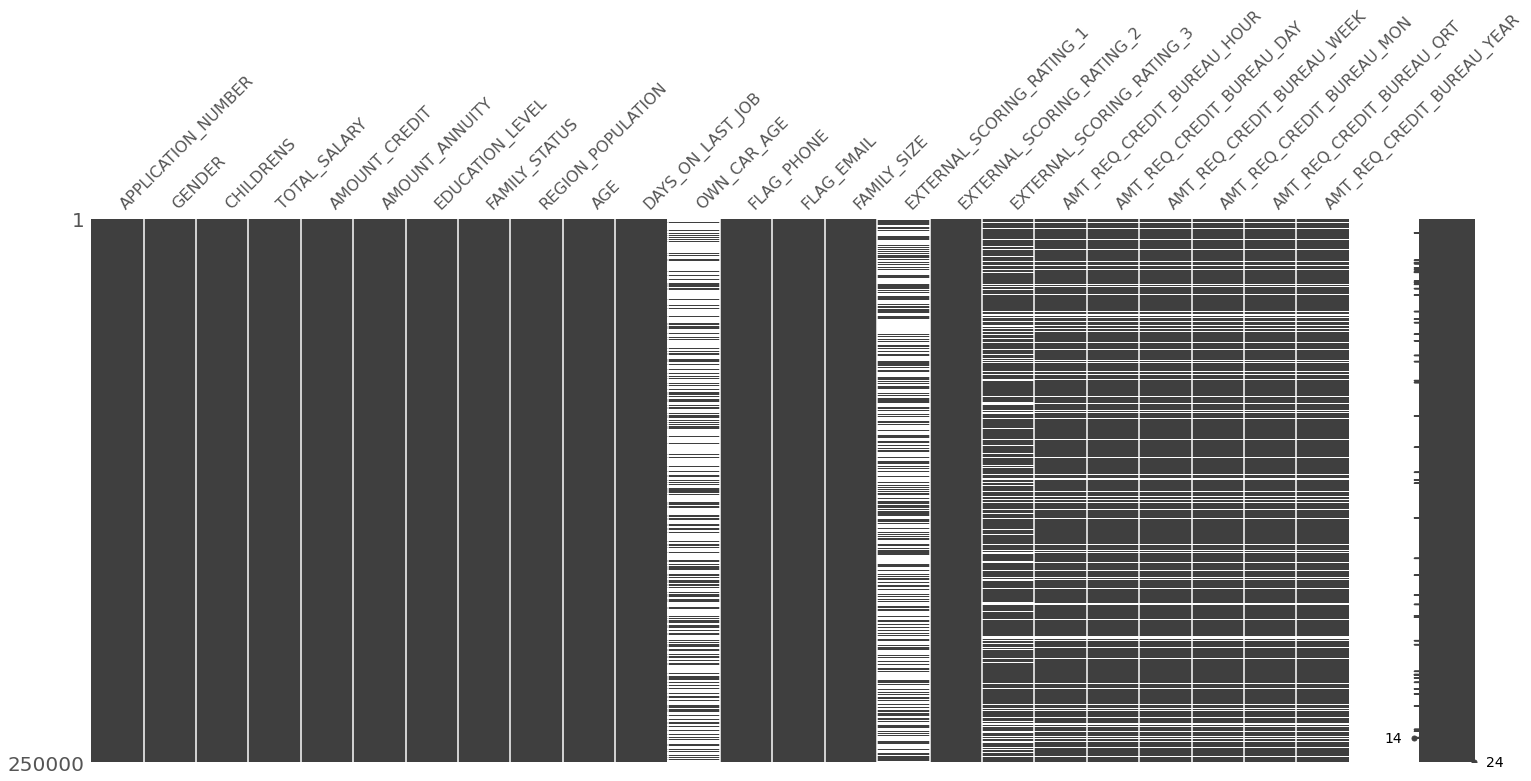

In [ ]:
#missing / outliers
msno.matrix(cp)

In [ ]:
len(cp_ids & train_ids), len(cp_ids & bki_ids), len(train_ids & (cp_ids & bki_ids))

(89539, 191604, 68723)

<AxesSubplot:>

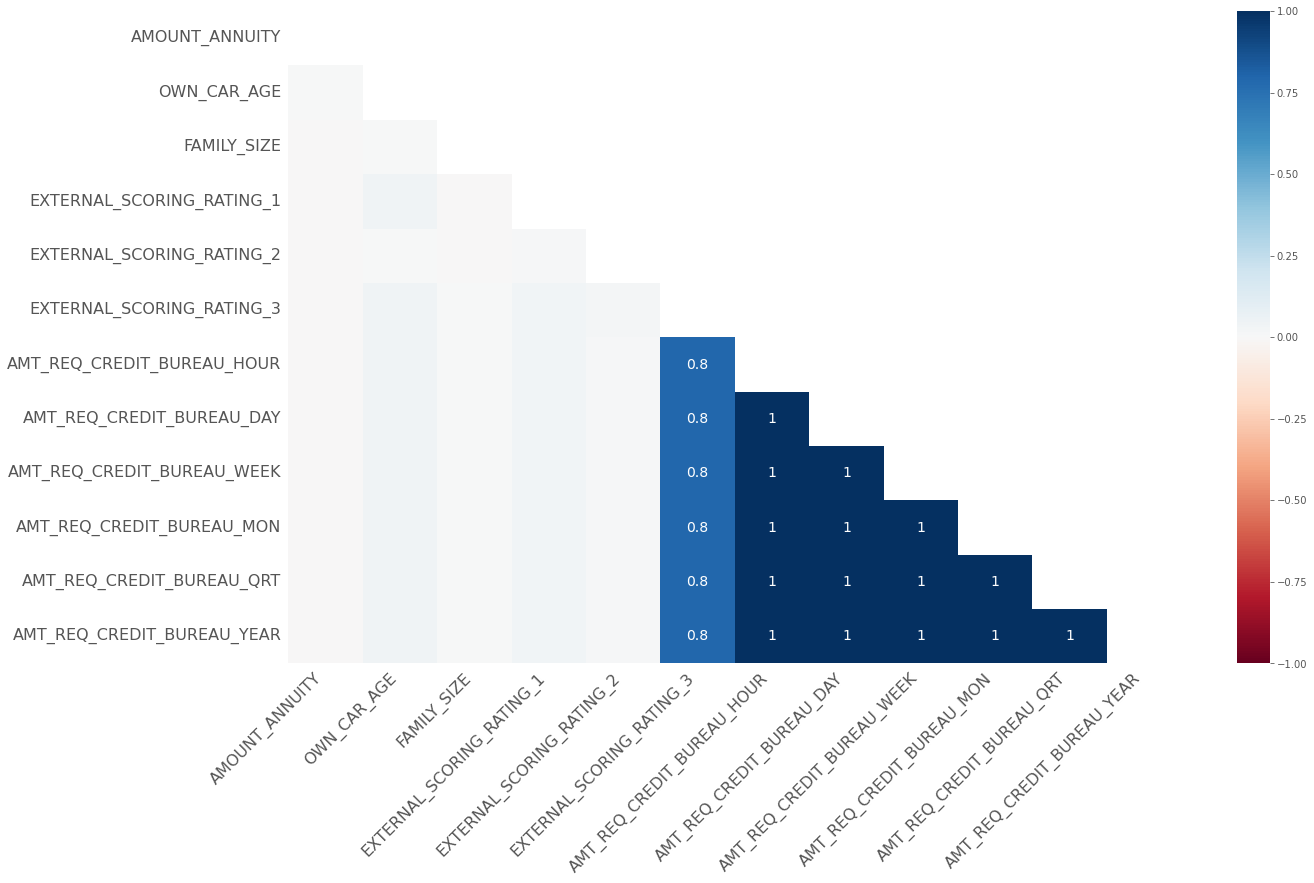

In [ ]:
msno.heatmap(cp)

In [ ]:
check_missings(cp)

Total NA-values = 558163


,AMOUNT_ANNUITY,OWN_CAR_AGE,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
Total,11,164959,2,140879,532,49538,33707,33707,33707,33707,33707,33707
Percent,0.0044,65.9836,0.0008,56.3516,0.2128,19.8152,13.4828,13.4828,13.4828,13.4828,13.4828,13.4828
Types,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64


In [ ]:
cp.fillna(0, inplace=True)

In [ ]:
cp.shape[0], cp[ID_COL].nunique()

(250000, 250000)

In [ ]:
cp.describe(include="object")

,GENDER,EDUCATION_LEVEL,FAMILY_STATUS
count,250000,250000,250000
unique,3,5,6
top,F,Secondary / secondary special,Married
freq,164645,177562,159846


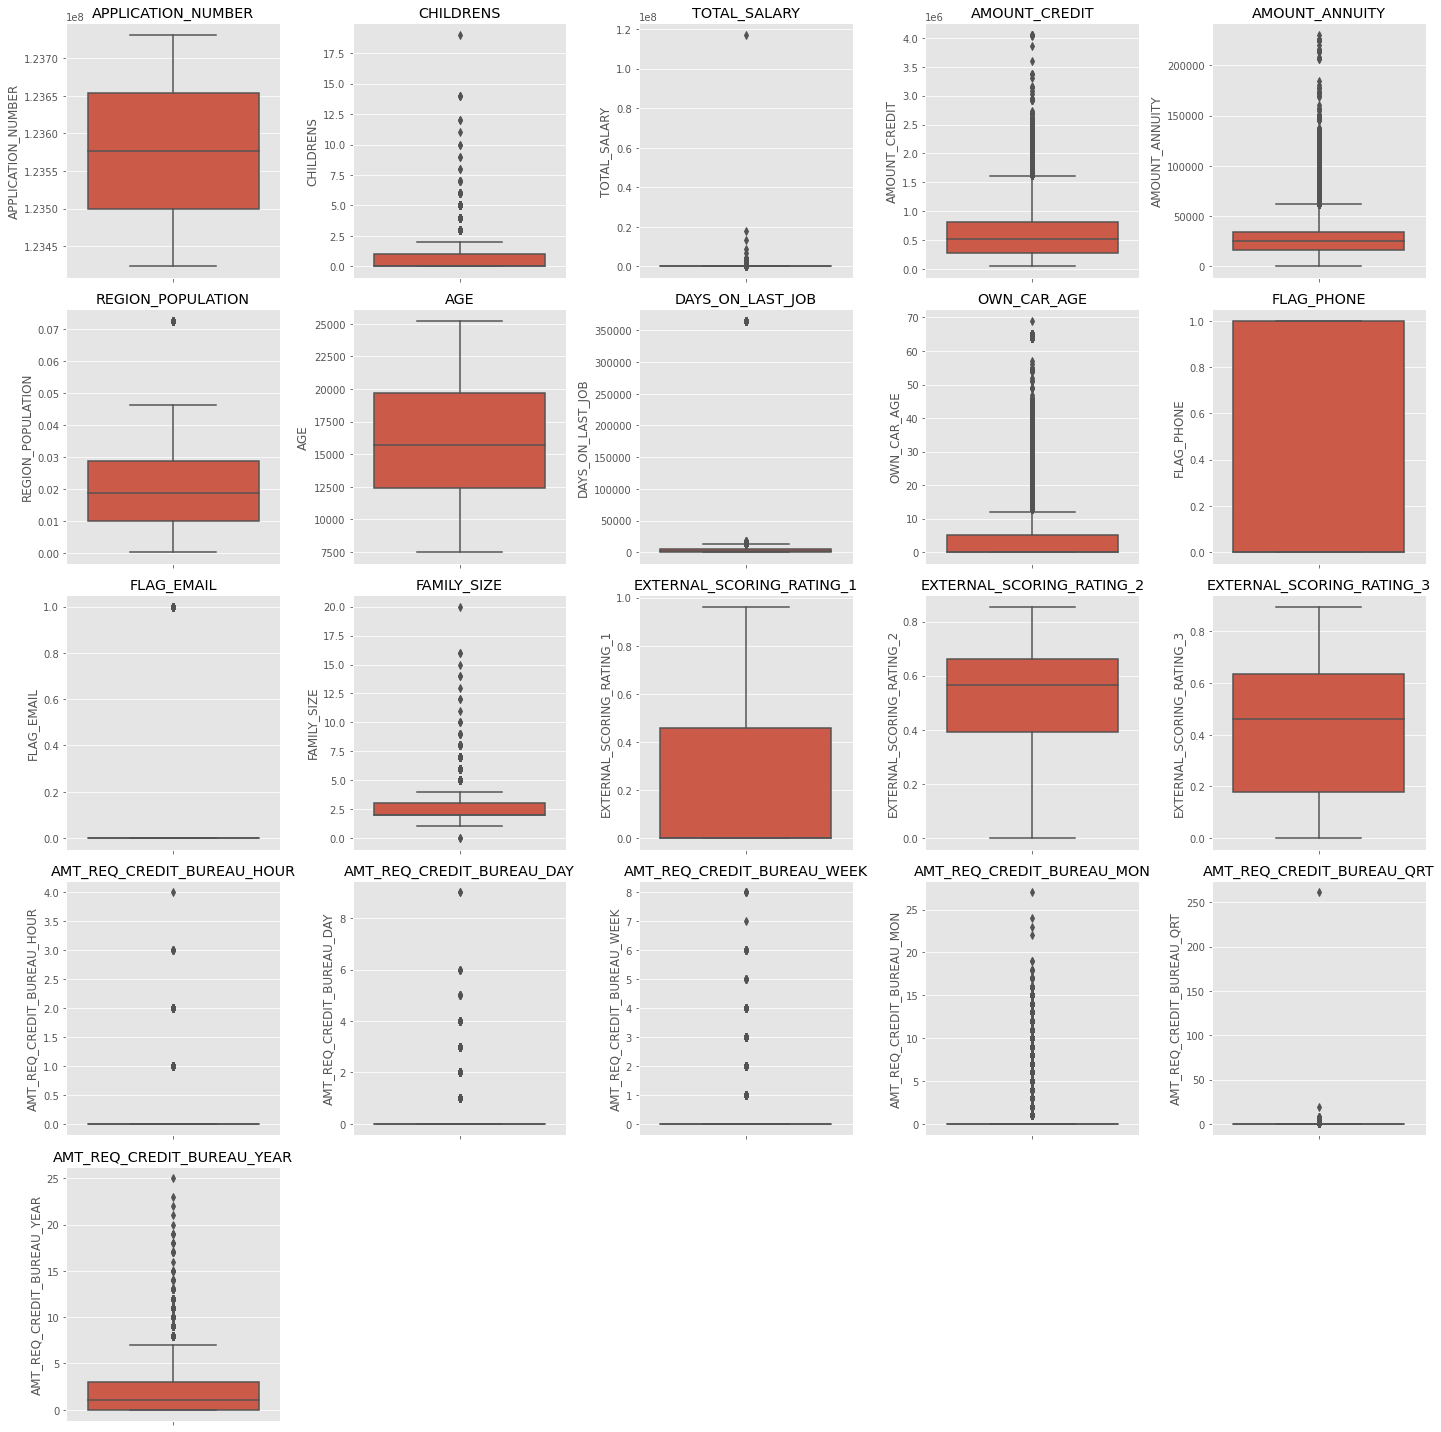

In [ ]:
# log for outliers
numerical_columns = cp.select_dtypes("number").columns
plt.figure(figsize=(20,20))
for idx, column in enumerate(numerical_columns, 1):
    plt.subplot(5, 5, idx)
    sns.boxplot(y=cp[column], data=cp)
    plt.title(f'{column}')
plt.tight_layout()
plt.show()

In [ ]:
# single point inspectation (dealing) + new feature based on IQR?
### cp[cp.AMT_REQ_CREDIT_BUREAU_QRT > 50] -> cp[cp.AMT_REQ_CREDIT_BUREAU_QRT <= 50].max() + 1
### cp[cp.DAYS_ON_LAST_JOB > 50000] -> 365.25
    # cp.REGION_POPULATION.hist(bins=10) OK - big cities
    # CHILDREN corresponds to FAMILY_SIZE
### cp[cp.TOTAL_SALARY < 1e+8]['TOTAL_SALARY'] /= 1000
cp[cp.TOTAL_SALARY > 1e+8]

,APPLICATION_NUMBER,GENDER,CHILDRENS,TOTAL_SALARY,AMOUNT_CREDIT,AMOUNT_ANNUITY,EDUCATION_LEVEL,FAMILY_STATUS,REGION_POPULATION,AGE,DAYS_ON_LAST_JOB,OWN_CAR_AGE,FLAG_PHONE,FLAG_EMAIL,FAMILY_SIZE,EXTERNAL_SCORING_RATING_1,EXTERNAL_SCORING_RATING_2,EXTERNAL_SCORING_RATING_3,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
146538,123436181,F,1,117000000.0000,562491.0000,26194.5000,Secondary / secondary special,Married,0.0106,12615,922,0.0000,0,0,3.0000,0.4608,0.1132,0.1455,0.0000,0.0000,0.0000,0.0000,0.0000,1.0000


In [ ]:
for column in cp.select_dtypes(include="object").columns:
    print(cp[column].value_counts(), '\n', '='*40)
# replace XNA with mode
# education: catboost target encoding df[edu] = ce.fit_transform/transform(df[edu], TARGET) (target from train)
# family status: union unknown with civil marriage

F      164645
M       85351
XNA         4
Name: GENDER, dtype: int64 
Secondary / secondary special    177562
Higher education                  60864
Incomplete higher                  8357
Lower secondary                    3081
Academic degree                     136
Name: EDUCATION_LEVEL, dtype: int64 
Married                 159846
Single / not married     36883
Civil marriage           24252
Separated                15984
Widow                    13033
Unknown                      2
Name: FAMILY_STATUS, dtype: int64 


In [ ]:
def prepare_cp(labels: pd.DataFrame, dropna: bool = True, create_features: bool = False) -> pd.DataFrame:
    df = pd.read_csv('client_profile.csv')
    # fill missing values: 0 is reasonable
    df.fillna(0, inplace=True)

    # deal with extreme outliers
    df.loc[df['AMT_REQ_CREDIT_BUREAU_QRT'] > 50] = df.loc[df['AMT_REQ_CREDIT_BUREAU_QRT'] <= 50, 'AMT_REQ_CREDIT_BUREAU_QRT'].max() + 1
    df.loc[df['DAYS_ON_LAST_JOB'] > 50000, 'DAYS_ON_LAST_JOB'] = 366
    df.loc[df['TOTAL_SALARY'] > 1e+8, 'TOTAL_SALARY'] /= 1000.

    # IQR mark
    df['IS_OUTLIER'] = 0
    for column in df.select_dtypes(include="number").columns:
        q1, q3 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
        iqr = q3 - q1
        upper_bound = q3 + 1.5 * iqr
        lower_bound = q1 - 1.5 * iqr
        condition = ((df[column] > upper_bound) | (df[column] < lower_bound))
        df.loc[condition, 'IS_OUTLIER'] = 1

    # transform categorical columns
    df.loc[df['GENDER'] == 'XNA', 'GENDER'] = df['GENDER'].mode()[0]
    df['GENDER'] = df['GENDER'].map({'F': 0, 'M': 1})
    df.loc[df['FAMILY_STATUS'] == 'Unknown', 'FAMILY_STATUS'] = 'Civil marriage'
    
    df['AGE'] = df['AGE'] / 365.25
    df['AGE_BIN'] = pd.cut(df['AGE'], bins=np.linspace(18, 70, 10), labels=False) + 1
    
    df = pd.merge(labels, df, on=ID_COL, how='left')
    df['NAME_CONTRACT_TYPE'] = df['NAME_CONTRACT_TYPE'].map({'Cash': 0, 'Credit Card': 1})

    if dropna:
        df.dropna(subset=df.columns.tolist()[3:], inplace=True) 
    if create_features:
        df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMOUNT_CREDIT'] / (df['AMOUNT_ANNUITY'] + 1)
        df['NEW_STATUS'] = df['GENDER'].map({0: 'F', 1: 'M'}) + df['FAMILY_STATUS'].astype(str)
        df["RATIO_ANNUITY_TO_AGE"] = df["AMOUNT_ANNUITY"] / df["AGE"]
        df["RATIO_CREDIT_TO_AGE"] = df["AMOUNT_CREDIT"] / df["AGE"]
        df["RATIO_SALARY_TO_AGE"] = df["TOTAL_SALARY"] / df["AGE"]
        df["RATIO_AGE_TO_EXPERIENCE"] = df["AGE"] / (df["DAYS_ON_LAST_JOB"] / 365.25 + 1)
        df["RATIO_CAR_TO_EXPERIENCE"] = df["OWN_CAR_AGE"] / (df["DAYS_ON_LAST_JOB"] / 365.25 + 1)
        df["RATIO_CAR_TO_AGE"] = df["OWN_CAR_AGE"] / df["AGE"]
        aggs = {
                "TOTAL_SALARY": ["mean", "max", "min", "count"],
                "AMOUNT_CREDIT": ["mean", "max", "min", "count"],
                "AMOUNT_ANNUITY": ["mean", "max", "min", "count"]
                }

        stat = create_numerical_aggs(df, groupby_id="EDUCATION_LEVEL", aggs=aggs, suffix="_BY_EDUCATION")
        df = df.merge(stat, on='EDUCATION_LEVEL', how='left')
        df["TOTAL_SALARY_TO_MEAN_SALARY_BY_EDUCATION"] = df["TOTAL_SALARY"] / (df["TOTAL_SALARY_MEAN_BY_EDUCATION"] + 1)
        df["DELTA_SALARY_TO_MEAN_SALARY_BY_EDUCATION"] = df["TOTAL_SALARY"] - df["TOTAL_SALARY_MEAN_BY_EDUCATION"]
        df["RATIO_SALARY_TO_AMOUNT_CREDIT"] = df["TOTAL_SALARY"] / df["AMOUNT_CREDIT"]
        df["RATIO_SALARY_TO_AMOUNT_CREDIT_BY_FAMILY"] = df["TOTAL_SALARY"] / (df["AMOUNT_CREDIT"] / (df["FAMILY_SIZE"] + 1))
        df["RATIO_AMOUNT_ANNUITY_TO_SALARY"] = df["AMOUNT_ANNUITY"] / (df["TOTAL_SALARY"]) # redundant
        df["RATIO_SALARY_TO_PER_FAMILY_SIZE"] = df["TOTAL_SALARY"] / (df["FAMILY_SIZE"] + 1)
        df["FLG_MORE_THAN_30PERCENT_FOR_CREDIT"] = np.where(df["RATIO_AMOUNT_ANNUITY_TO_SALARY"] > 0.3, 1, 0)
        df["EDUCATION_FAMILY_STATUS"] = df["EDUCATION_LEVEL"] + " | " + df["FAMILY_STATUS"]
        stat = create_numerical_aggs(df, groupby_id="AGE_BIN", aggs=aggs, suffix="_AGE_INTERVAL")
        df = df.merge(stat, on='AGE_BIN', how='left')
        stat = create_numerical_aggs(df, groupby_id="FAMILY_STATUS", aggs=aggs, suffix="_BY_FAMILY_STATUS")
        df = df.merge(stat, on='FAMILY_STATUS', how='left')

        aggs = {"NEW_CREDIT_TO_ANNUITY_RATIO": ["mean"],
                "RATIO_SALARY_TO_AMOUNT_CREDIT": ["mean"]}
        stat = create_numerical_aggs(df, groupby_id=["GENDER", "AGE_BIN"], aggs=aggs, suffix="_GENDER_AGE_BIN")
        df = df.merge(stat, on=["GENDER", "AGE_BIN"], how='left')
        df['EXT_SCORE_1_AMT_CREDIT'] = df['EXTERNAL_SCORING_RATING_1'] * df['AMOUNT_CREDIT']
        df['EXT_SCORE_2_AMT_CREDIT'] = df['EXTERNAL_SCORING_RATING_2'] * df['AMOUNT_CREDIT']
        df['EXT_SCORE_3_AMT_CREDIT'] = df['EXTERNAL_SCORING_RATING_3'] * df['AMOUNT_CREDIT']
        
        df['EXT_SCORE_1_ANNUITY'] = df['EXTERNAL_SCORING_RATING_1'] * df['AMOUNT_ANNUITY']
        df['EXT_SCORE_2_ANNUITY'] = df['EXTERNAL_SCORING_RATING_2'] * df['AMOUNT_ANNUITY']
        df['EXT_SCORE_3_ANNUITY'] = df['EXTERNAL_SCORING_RATING_3'] * df['AMOUNT_ANNUITY']
        
        df['SALARY_REGION_POPULATION'] = df['TOTAL_SALARY'] * df['REGION_POPULATION']
        df['SALARY_JOB'] = df['TOTAL_SALARY'] / (df["DAYS_ON_LAST_JOB"] / 365.25 + 1)
        df['CREDIT_JOB'] = df['AMOUNT_CREDIT'] / (df["DAYS_ON_LAST_JOB"] / 365.25 + 1)
        df['ANNUITY_JOB'] = df['AMOUNT_ANNUITY'] / (df["DAYS_ON_LAST_JOB"] / 365.25 + 1)
        funcs = ["min", "max", "mean", "nanmedian", "var"]
        for func in funcs:
            df[f"EXT_SCORES_{func}"] = eval("np.{}".format(func))(df[['EXTERNAL_SCORING_RATING_1',
                                                                      'EXTERNAL_SCORING_RATING_2',
                                                                      'EXTERNAL_SCORING_RATING_3']], axis=1)

    df = reduce_memory_df(df)
    df.set_index(ID_COL, inplace=True)

    return df

In [ ]:
data.shape, len((train_ids | test_ids) & cp_ids), data_train.shape, data_test.shape

((223714, 96), 223715, (89539, 96), (134175, 96))

In [ ]:
data = pd.concat([train, test], axis=0)
data = prepare_cp(data, create_features=True, dropna=True)
train_bound = len(data) - data[TARGET].isna().sum()

Memory usage of dataframe is 166.41 MB
Memory usage after optimization is: 80.65 MB
Decreased by 51.5%


In [ ]:
# data_train, data_test = data[~data[TARGET].isna()], data[data[TARGET].isna()]
data_train, data_test = data.iloc[:train_bound, :], data.iloc[train_bound:, :]
data_train[TARGET] = data_train[TARGET].astype(int)

In [ ]:
data_train[TARGET].value_counts(normalize=True)

0   0.9195
1   0.0805
Name: TARGET, dtype: float64

In [ ]:
x_train, x_test, y_learn, y_valid = train_test_split(data_train.drop(TARGET, axis=1), data_train[TARGET], 
                                                     test_size=0.2, shuffle=True,
                                                     random_state=seed)

In [ ]:
X_inspect = pd.concat([x_train, x_test], axis=0)
y_inspect = np.hstack((np.ones(x_train.shape[0]), np.zeros(x_test.shape[0])))

inspector = LGBMClassifier(max_depth=4, 
                           n_estimators=100,
                           verbose=-1,
                           is_unbalance=True,
                           learning_rate=0.05,   
                           random_seed=seed)
model.fit(X_inspect, y_inspect)

cv = cross_val_score(
    estimator=model,
    X=X_inspect, y=y_inspect,
    scoring="roc_auc",
    cv=KFold(n_splits=5, shuffle=True, random_state=42)
)

print(f"CV-score: {round(np.mean(cv), 4)}")

# the split is ok

CV-score: 0.5


In [ ]:
x_train.describe(include="category")

,EDUCATION_LEVEL,FAMILY_STATUS,NEW_STATUS,EDUCATION_FAMILY_STATUS
count,88074,88074,88074,88074
unique,5,5,10,25
top,Secondary / secondary special,Married,FMarried,Secondary / secondary special | Married
freq,62417,56171,35067,39854


In [ ]:
# WoE for x_train | catboost
encoder = ce.woe.WOEEncoder(random_state=seed)
x_train[['EDUCATION_LEVEL', 'FAMILY_STATUS', 'NEW_STATUS', 'EDUCATION_FAMILY_STATUS']] = \
        encoder.fit_transform(x_train[['EDUCATION_LEVEL', 'FAMILY_STATUS', 
                                       'NEW_STATUS', 'EDUCATION_FAMILY_STATUS']], y_learn)
x_test[['EDUCATION_LEVEL', 'FAMILY_STATUS', 'NEW_STATUS', 'EDUCATION_FAMILY_STATUS']] = \
        encoder.transform(x_test[['EDUCATION_LEVEL', 'FAMILY_STATUS', 
                                   'NEW_STATUS', 'EDUCATION_FAMILY_STATUS']])

In [ ]:
boruta_params = {
                'metric':"auc", 
                'boosting_type': 'gbdt',
                'is_unbalance': True,
                'n_estimators': 150,
                'learning_rate': 0.01,
                'min_child_weight': 600,
                'max_depth': 3,
                'verbose': -1,
                'reg_alpha': 25,
                'reg_lambda': 25,
                'colsample_bytree': 0.33,
                'num_leaves': 42,
                'subsample': 0.33,
                'random_state': seed
}

selector = BorutaShap(model=LGBMClassifier(**boruta_params), importance_measure='shap', classification=True)
selector.fit(x_train, y_learn, n_trials=25, sample=True, normalize=True, verbose=True)

  0%|          | 0/25 [00:00<?, ?it/s]

38 attributes confirmed important: ['RATIO_AMOUNT_ANNUITY_TO_SALARY', 'CREDIT_JOB', 'ANNUITY_JOB', 'RATIO_CAR_TO_AGE', 'AGE', 'DAYS_ON_LAST_JOB', 'RATIO_CREDIT_TO_AGE', 'EXT_SCORE_2_AMT_CREDIT', 'RATIO_SALARY_TO_AMOUNT_CREDIT_MEAN_GENDER_AGE_BIN', 'EXT_SCORES_mean', 'AMOUNT_CREDIT_MEAN_BY_EDUCATION', 'EDUCATION_FAMILY_STATUS', 'RATIO_SALARY_TO_AMOUNT_CREDIT', 'EXT_SCORE_1_AMT_CREDIT', 'EXTERNAL_SCORING_RATING_2', 'TOTAL_SALARY_MAX_AGE_INTERVAL', 'EXT_SCORE_3_AMT_CREDIT', 'EXT_SCORES_nanmedian', 'RATIO_AGE_TO_EXPERIENCE', 'GENDER', 'EXT_SCORE_2_ANNUITY', 'EXT_SCORES_max', 'EXT_SCORES_var', 'EXT_SCORES_min', 'EDUCATION_LEVEL', 'NAME_CONTRACT_TYPE', 'EXTERNAL_SCORING_RATING_3', 'RATIO_ANNUITY_TO_AGE', 'TOTAL_SALARY_MEAN_BY_EDUCATION', 'NEW_CREDIT_TO_ANNUITY_RATIO', 'EXT_SCORE_3_ANNUITY', 'EXTERNAL_SCORING_RATING_1', 'AGE_BIN', 'EXT_SCORE_1_ANNUITY', 'AMOUNT_ANNUITY_MEAN_BY_EDUCATION', 'AMOUNT_CREDIT_MAX_BY_EDUCATION', 'NEW_STATUS', 'AMOUNT_CREDIT']
45 attributes confirmed unimportant: ['C

In [ ]:
features = ['RATIO_AMOUNT_ANNUITY_TO_SALARY', 'RATIO_CAR_TO_AGE', 'AGE', 'DAYS_ON_LAST_JOB', 'RATIO_CREDIT_TO_AGE', 
            'RATIO_SALARY_TO_AMOUNT_CREDIT_MEAN_GENDER_AGE_BIN', 'AMOUNT_CREDIT_MEAN_BY_EDUCATION', 'EDUCATION_FAMILY_STATUS', 
            'RATIO_SALARY_TO_AMOUNT_CREDIT', 'EXTERNAL_SCORING_RATING_2', 'TOTAL_SALARY_COUNT_BY_EDUCATION', 
            'RATIO_AGE_TO_EXPERIENCE', 'GENDER', 'OWN_CAR_AGE', 'AMOUNT_ANNUITY_COUNT_AGE_INTERVAL', 
            'AMOUNT_ANNUITY_MAX_BY_EDUCATION', 'NEW_CREDIT_TO_ANNUITY_RATIO_MEAN_GENDER_AGE_BIN', 'EDUCATION_LEVEL', 
            'NAME_CONTRACT_TYPE', 'EXTERNAL_SCORING_RATING_3', 'REGION_POPULATION', 'RATIO_ANNUITY_TO_AGE', 
            'NEW_CREDIT_TO_ANNUITY_RATIO', 'TOTAL_SALARY_MEAN_BY_EDUCATION', 'EXTERNAL_SCORING_RATING_1', 
            'AGE_BIN', 'AMOUNT_ANNUITY_MEAN_BY_EDUCATION', 'AMOUNT_CREDIT_MAX_BY_EDUCATION', 'NEW_STATUS', 
            'AMOUNT_ANNUITY', 'AMOUNT_CREDIT', 'TOTAL_SALARY_MEAN_BY_FAMILY_STATUS', 'TOTAL_SALARY_MAX_AGE_INTERVAL', 
            'TOTAL_SALARY', 'TOTAL_SALARY_MIN_BY_EDUCATION', 'RATIO_SALARY_TO_AMOUNT_CREDIT_BY_FAMILY', 
            'TOTAL_SALARY_MAX_BY_FAMILY_STATUS', 'AMOUNT_CREDIT_COUNT_BY_FAMILY_STATUS', 'RATIO_SALARY_TO_AGE', 
            'FAMILY_STATUS', 'AMOUNT_CREDIT_COUNT_BY_EDUCATION', 'RATIO_CAR_TO_EXPERIENCE']

features = ['RATIO_AMOUNT_ANNUITY_TO_SALARY', 'CREDIT_JOB', 'ANNUITY_JOB', 'RATIO_CAR_TO_AGE', 'AGE', 'DAYS_ON_LAST_JOB', 
            'RATIO_CREDIT_TO_AGE', 'EXT_SCORE_2_AMT_CREDIT', 'RATIO_SALARY_TO_AMOUNT_CREDIT_MEAN_GENDER_AGE_BIN', 
            'EXT_SCORES_mean', 'AMOUNT_CREDIT_MEAN_BY_EDUCATION', 'EDUCATION_FAMILY_STATUS', 'RATIO_SALARY_TO_AMOUNT_CREDIT', 
            'EXT_SCORE_1_AMT_CREDIT', 'EXTERNAL_SCORING_RATING_2', 'TOTAL_SALARY_MAX_AGE_INTERVAL', 'EXT_SCORE_3_AMT_CREDIT', 
            'EXT_SCORES_nanmedian', 'RATIO_AGE_TO_EXPERIENCE', 'GENDER', 'EXT_SCORE_2_ANNUITY', 'EXT_SCORES_max', 
            'EXT_SCORES_var', 'EXT_SCORES_min', 'EDUCATION_LEVEL', 'NAME_CONTRACT_TYPE', 'EXTERNAL_SCORING_RATING_3', 
            'RATIO_ANNUITY_TO_AGE', 'TOTAL_SALARY_MEAN_BY_EDUCATION', 'NEW_CREDIT_TO_ANNUITY_RATIO', 'EXT_SCORE_3_ANNUITY', 
            'EXTERNAL_SCORING_RATING_1', 'AGE_BIN', 'EXT_SCORE_1_ANNUITY', 'AMOUNT_ANNUITY_MEAN_BY_EDUCATION', 
            'AMOUNT_CREDIT_MAX_BY_EDUCATION', 'NEW_STATUS', 'AMOUNT_CREDIT', 'OWN_CAR_AGE', 'REGION_POPULATION', 
            'AMOUNT_ANNUITY_MAX_BY_EDUCATION', 'AMOUNT_CREDIT_MEAN_AGE_INTERVAL', 'RATIO_SALARY_TO_AMOUNT_CREDIT_BY_FAMILY', 
            'AMOUNT_ANNUITY_COUNT_BY_EDUCATION', 'TOTAL_SALARY_COUNT_BY_EDUCATION', 'TOTAL_SALARY_MAX_BY_FAMILY_STATUS', 
            'TOTAL_SALARY_MIN_AGE_INTERVAL', 'SALARY_JOB', 'AMOUNT_ANNUITY', 'RATIO_SALARY_TO_AGE']

**LGBM**

In [ ]:
lgbm_params = {
                'metric':"auc", 
                'boosting_type': 'goss',
                'is_unbalance': True,
                'n_estimators': 200, 
                'learning_rate': 0.05, 
                'min_child_weight': 650, 
                'min_split_gain': 0.024766,
                'max_depth': 3,
                'verbose': -1,
                'reg_alpha': 30,
                'reg_lambda': 30,
                'colsample_bytree': 0.33,
                'num_leaves': 42,
                'subsample': 0.33,
                'max_bin': 128,
                'random_state': seed
}

lgbm_estimators, oof_score, fold_train_scores, fold_valid_scores, oof_lgbm = make_modify_cross_validation(
        x_train[features], 
        y_learn, 
        LGBMClassifier(**lgbm_params), 
        metric=roc_auc_score, 
        cv_strategy=KFold(n_splits=10, shuffle=True, random_state=seed), 
        error_to_be_outlier=False,
        early=False
        )

Fold: 1, train-observations = 64467, valid-observations = 7164
train-score = 0.7671, valid-score = 0.7658
Fold: 2, train-observations = 64468, valid-observations = 7163
train-score = 0.7687, valid-score = 0.7501
Fold: 3, train-observations = 64468, valid-observations = 7163
train-score = 0.7695, valid-score = 0.7458
Fold: 4, train-observations = 64468, valid-observations = 7163
train-score = 0.7686, valid-score = 0.753
Fold: 5, train-observations = 64468, valid-observations = 7163
train-score = 0.7683, valid-score = 0.7503
Fold: 6, train-observations = 64468, valid-observations = 7163
train-score = 0.7695, valid-score = 0.7416
Fold: 7, train-observations = 64468, valid-observations = 7163
train-score = 0.7697, valid-score = 0.7429
Fold: 8, train-observations = 64468, valid-observations = 7163
train-score = 0.7683, valid-score = 0.7535
Fold: 9, train-observations = 64468, valid-observations = 7163
train-score = 0.7678, valid-score = 0.7543
Fold: 10, train-observations = 64468, valid-obs

In [ ]:
lgbm = LGBMClassifier(**lgbm_params).fit(x_train[features], y_learn)
valid_lgbm_predictions = lgbm.predict_proba(x_test[features])[:,1]

print(roc_auc_score(y_learn, lgbm.predict_proba(x_train[features])[:,1]))
print(roc_auc_score(y_valid, lgbm.predict_proba(x_test[features])[:,1]))

0.7672399564739565
0.7516373903862517


In [ ]:
scores = create_bootstrap_metrics(y_valid, lgbm.predict_proba(x_test[features])[:,1], roc_auc_score)

calculate_confidence_interval(scores)

(0.7388627721331597, 0.7643936086485015)

**XGBoost**

In [ ]:
xg_params = {
        "booster": "gbtree",
        # "scale_pos_weight": np.sum(y==0)/np.sum(y==1),
        "n_estimators": 200,
        "objective": "binary:logistic",
        "eval_metric": "auc",
        "learning_rate": 0.05,
        "reg_lambda": 10,
        "min_child_weight": 600,
        "colsample_bylevel": 0.8,
        "max_depth": 4,
        "gamma": 10,
        "nthread": -1,
        "grow_policy": "depthwise",
        "seed": seed,
}
xgb_estimators, oof_score, fold_train_scores, fold_valid_scores, oof_xgb = make_modify_cross_validation(
                            x_train[features], 
                            y_learn, 
                            XGBClassifier(**xg_params), 
                            metric=roc_auc_score, 
                            cv_strategy=KFold(n_splits=10, shuffle=True, random_state=seed), 
                            error_to_be_outlier=False
                        )

Fold: 1, train-observations = 64467, valid-observations = 7164
train-score = 0.7529, valid-score = 0.7622
Fold: 2, train-observations = 64468, valid-observations = 7163
train-score = 0.753, valid-score = 0.7406
Fold: 3, train-observations = 64468, valid-observations = 7163
train-score = 0.7551, valid-score = 0.7359
Fold: 4, train-observations = 64468, valid-observations = 7163
train-score = 0.7547, valid-score = 0.7442
Fold: 5, train-observations = 64468, valid-observations = 7163
train-score = 0.7541, valid-score = 0.7407
Fold: 6, train-observations = 64468, valid-observations = 7163
train-score = 0.7557, valid-score = 0.7344
Fold: 7, train-observations = 64468, valid-observations = 7163
train-score = 0.7555, valid-score = 0.7322
Fold: 8, train-observations = 64468, valid-observations = 7163
train-score = 0.7539, valid-score = 0.7419
Fold: 9, train-observations = 64468, valid-observations = 7163
train-score = 0.7539, valid-score = 0.7386
Fold: 10, train-observations = 64468, valid-obs

In [ ]:
xgb = XGBClassifier(**xg_params).fit(x_train[features], y_learn)
valid_xgb_predictions = xgb.predict_proba(x_test[features])[:,1]

print(roc_auc_score(y_learn, xgb.predict_proba(x_train[features])[:,1]))
print(roc_auc_score(y_valid, xgb.predict_proba(x_test[features])[:,1]))

0.7567557936296271
0.7424985989516812


In [ ]:
scores = create_bootstrap_metrics(y_valid, xgb.predict_proba(x_test[features])[:,1], roc_auc_score)

calculate_confidence_interval(scores)

(0.7297199771442415, 0.7557449048001685)

**Logreg**

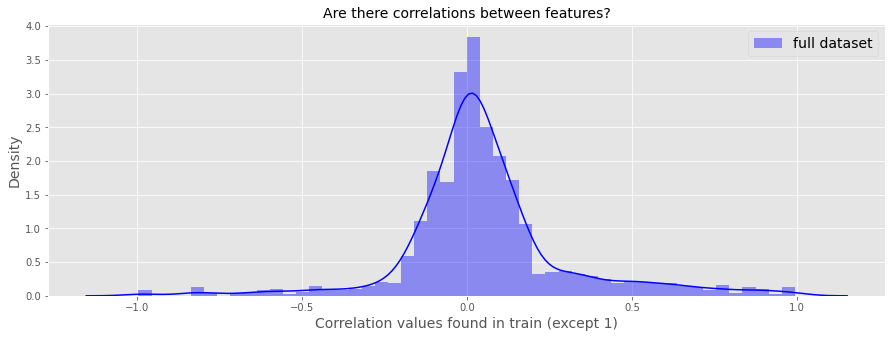

In [ ]:
train_correlations = x_train[features].corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

columns = X_train[selected].columns.tolist()

plt.figure(figsize=(15,5))
sns.distplot(train_correlations, color="Blue", label="full dataset")

plt.xlabel("Correlation values found in train (except 1)", size=14)
plt.title("Are there correlations between features?", size=14)
plt.legend(loc="best", fontsize=14)
plt.ylabel("Density", size=14)
plt.show()

In [ ]:
logreg = make_pipeline(StandardScaler(),
                       PCA(n_components=x_train[features].shape[1]-5, random_state=seed),
                       LogisticRegression(class_weight='balanced', 
                                          solver='liblinear', 
                                          penalty='l1', 
                                          C=10,
                                          random_state=seed,
                                          n_jobs=-1))

log_estimators, oof_score, fold_train_scores, fold_valid_scores, oof_log = make_modify_cross_validation(
                            x_train[features], 
                            y_learn, 
                            logreg, 
                            metric=roc_auc_score, 
                            cv_strategy=KFold(n_splits=10, shuffle=True, random_state=seed), 
                            error_to_be_outlier=False
                        )

Fold: 1, train-observations = 64467, valid-observations = 7164
train-score = 0.7245, valid-score = 0.7438
Fold: 2, train-observations = 64468, valid-observations = 7163
train-score = 0.7262, valid-score = 0.7279
Fold: 3, train-observations = 64468, valid-observations = 7163
train-score = 0.7271, valid-score = 0.7189
Fold: 4, train-observations = 64468, valid-observations = 7163
train-score = 0.727, valid-score = 0.7215
Fold: 5, train-observations = 64468, valid-observations = 7163
train-score = 0.7272, valid-score = 0.7177
Fold: 6, train-observations = 64468, valid-observations = 7163
train-score = 0.7278, valid-score = 0.7145
Fold: 7, train-observations = 64468, valid-observations = 7163
train-score = 0.7274, valid-score = 0.7177
Fold: 8, train-observations = 64468, valid-observations = 7163
train-score = 0.7265, valid-score = 0.7264
Fold: 9, train-observations = 64468, valid-observations = 7163
train-score = 0.7272, valid-score = 0.7187
Fold: 10, train-observations = 64468, valid-obs

In [ ]:
logreg = logreg.fit(x_train[features], y_learn)
valid_log_predictions = logreg.predict_proba(x_test[features])[:,1]

print(roc_auc_score(y_learn, logreg.predict_proba(x_train[features])[:,1]))
print(roc_auc_score(y_valid, logreg.predict_proba(x_test[features])[:,1]))

0.7265344638194042
0.7247908002842712


In [ ]:
scores = create_bootstrap_metrics(y_valid, logreg.predict_proba(x_test[features])[:,1], roc_auc_score)

calculate_confidence_interval(scores)

(0.7115792895125729, 0.737306074606931)

**catboost**

In [ ]:
# preserve cat features
x_train, x_test, y_learn, y_valid = train_test_split(data_train.drop(TARGET, axis=1), data_train[TARGET], 
                                                     test_size=0.2, shuffle=True,
                                                     random_state=seed)

In [ ]:
cat_params = {
                'silent': True, 
                'one_hot_max_size': 2,  
                'iterations': 200, 
                'eval_metric': 'AUC',
                'allow_writing_files': False, 
                'random_seed': seed,
                'auto_class_weights': 'SqrtBalanced',
                'grow_policy': 'SymmetricTree', 
                'objective': 'Logloss',
                'boosting_type': 'Ordered', 
                'score_function': 'Cosine', 
                'bootstrap_type': 'MVS', 
                'bagging_temperature': 10, 
                'colsample_bylevel': 0.8, 
                'depth': 3, 
                'l2_leaf_reg': 40, 
                'learning_rate': 0.03,
                'max_ctr_complexity': 3, 
                'od_type': 'Iter',
                'subsample': 0.8, 
                'max_bin': 128,  
} 

cat_features = ['EDUCATION_FAMILY_STATUS', 'EDUCATION_LEVEL', 'NEW_STATUS',] # 'FAMILY_STATUS']

cat_estimators, oof_score, fold_train_scores, fold_valid_scores, oof_cat = make_modify_cross_validation(
                            x_train[features], 
                            y_learn, 
                            CatBoostClassifier(cat_features=cat_features, **cat_params), 
                            metric=roc_auc_score, 
                            cv_strategy=KFold(n_splits=10, shuffle=True, random_state=seed), 
                            error_to_be_outlier=False,
                        )

Fold: 1, train-observations = 64467, valid-observations = 7164
train-score = 0.7466, valid-score = 0.7612
Fold: 2, train-observations = 64468, valid-observations = 7163
train-score = 0.7482, valid-score = 0.7464
Fold: 3, train-observations = 64468, valid-observations = 7163
train-score = 0.7487, valid-score = 0.738
Fold: 4, train-observations = 64468, valid-observations = 7163
train-score = 0.7492, valid-score = 0.7425
Fold: 5, train-observations = 64468, valid-observations = 7163
train-score = 0.7487, valid-score = 0.7415
Fold: 6, train-observations = 64468, valid-observations = 7163
train-score = 0.7503, valid-score = 0.7306
Fold: 7, train-observations = 64468, valid-observations = 7163
train-score = 0.7494, valid-score = 0.7322
Fold: 8, train-observations = 64468, valid-observations = 7163
train-score = 0.7484, valid-score = 0.7422
Fold: 9, train-observations = 64468, valid-observations = 7163
train-score = 0.7484, valid-score = 0.7403
Fold: 10, train-observations = 64468, valid-obs

In [ ]:
cat = CatBoostClassifier(cat_features=cat_features, **cat_params).fit(x_train[features], y_learn)
valid_cat_predictions = cat.predict_proba(x_test[features])[:,1]

print(roc_auc_score(y_learn, cat.predict_proba(x_train[features])[:,1]))
print(roc_auc_score(y_valid, cat.predict_proba(x_test[features])[:,1]))

0.7487080671474996
0.7408580202992593


In [ ]:
scores = create_bootstrap_metrics(y_valid, cat.predict_proba(x_test[features])[:,1], roc_auc_score)

calculate_confidence_interval(scores)

(0.7291963826719704, 0.7543980178969778)

**ensembling & stacking**

In [ ]:
oof_predictions = pd.DataFrame({'logreg': oof_log, 'lgbm': oof_lgbm, 'xgb': oof_xgb, 'cat': oof_cat})
oof_predictions.sample(5)

,logreg,lgbm,xgb,cat
6730,0.6216,0.5285,0.0963,0.2662
50767,0.4497,0.4418,0.0558,0.2005
18799,0.3291,0.1503,0.0311,0.0926
26942,0.3004,0.1933,0.0314,0.1194
14543,0.5356,0.4820,0.0841,0.2197


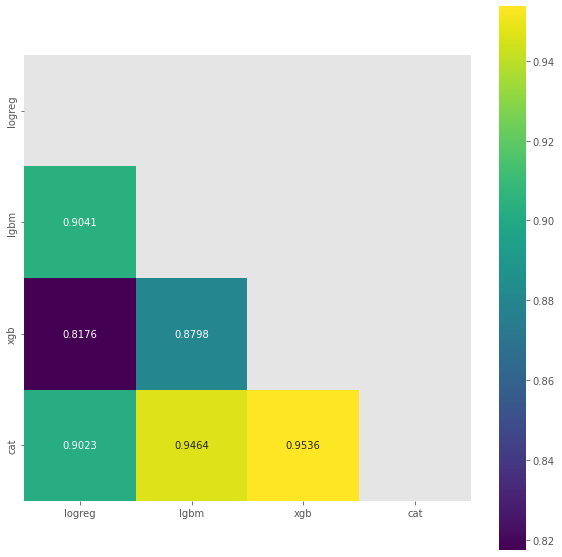

In [ ]:
corr = oof_predictions.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)
plt.show()

In [ ]:
mean_scores(oof_predictions, y_learn)

AMean score: 0.74454
GMean score: 0.74497
Rank  score: 0.74437
GMean  rank: 0.74444


In [ ]:
from scipy.optimize import minimize

results_list = []   
weights_list = []  
preds = oof_predictions.values

def weights_objective(weights):
    y_ens = np.average(preds, axis=1, weights=weights)
    return roc_auc_score(y_learn, y_ens)

for k in range(100):
  
    w0 = np.random.uniform(size=preds.shape[1])
    bounds = [(0,1)] * preds.shape[1]

    cons = [{'type': 'eq',
             'fun': lambda w: w.sum() - 1}]

    res = minimize(weights_objective,
                   w0,
                   method='SLSQP',
                   bounds=bounds,
                   options={'disp':False, 'maxiter':10000},
                   constraints=cons)

    results_list.append(res.fun)
    weights_list.append(res.x)

best_score = np.max(results_list)    
best_weights = weights_list[results_list.index(best_score)]

print('\nOptimized weights:')
print('Best score: {:.4f}'.format(best_score))


Optimized weights:
Best score: 0.7507


In [ ]:
valid_predictions = pd.DataFrame({'logreg': valid_log_predictions, 
                                  'lgbm': valid_lgbm_predictions, 
                                  'xgb': valid_xgb_predictions, 
                                  'cat': valid_cat_predictions})
valid_predictions.sample(5)

,logreg,lgbm,xgb,cat
14249,0.5940,0.5673,0.1000,0.2791
574,0.4850,0.5706,0.1068,0.2467
14696,0.3837,0.3359,0.0384,0.1703
2559,0.2270,0.2011,0.0309,0.1112
9771,0.4070,0.3172,0.0514,0.1754


In [ ]:
optimized_scores = np.average(valid_predictions, axis=1, weights=best_weights)
roc_auc_score(y_valid, optimized_scores)

0.7504572057866926

In [ ]:
# CI optimized
scores = create_bootstrap_metrics(y_valid, optimized_scores, roc_auc_score)

calculate_confidence_interval(scores)

(0.737174339382868, 0.7633692382258066)

In [ ]:
geo_optimized_scores = stats.gmean(valid_predictions, axis=1, weights=best_weights)
roc_auc_score(y_valid, geo_optimized_scores)

0.747725229960274

In [ ]:
scores = create_bootstrap_metrics(y_valid, geo_optimized_scores, roc_auc_score)

calculate_confidence_interval(scores)

(0.7351149630015194, 0.75997103367366)

In [ ]:
# LDA assumes correletions between variables
lda = LinearDiscriminantAnalysis(
                                 solver='eigen',
                                 shrinkage='auto',
                                 store_covariance=True,
                                 n_components=1
                                )

lda_estimators, _, _, _, oof_lda = make_modify_cross_validation(
                                                          oof_predictions, 
                                                          y_learn, 
                                                          lda, 
                                                          metric=roc_auc_score, 
                                                          cv_strategy=KFold(n_splits=10, shuffle=True, random_state=seed), 
                                                          error_to_be_outlier=False
                                                          )

Fold: 1, train-observations = 64467, valid-observations = 7164
train-score = 0.7457, valid-score = 0.7644
Fold: 2, train-observations = 64468, valid-observations = 7163
train-score = 0.7478, valid-score = 0.7444
Fold: 3, train-observations = 64468, valid-observations = 7163
train-score = 0.7481, valid-score = 0.7419
Fold: 4, train-observations = 64468, valid-observations = 7163
train-score = 0.7473, valid-score = 0.7503
Fold: 5, train-observations = 64468, valid-observations = 7163
train-score = 0.7475, valid-score = 0.7483
Fold: 6, train-observations = 64468, valid-observations = 7163
train-score = 0.7482, valid-score = 0.7386
Fold: 7, train-observations = 64468, valid-observations = 7163
train-score = 0.7485, valid-score = 0.7378
Fold: 8, train-observations = 64468, valid-observations = 7163
train-score = 0.7475, valid-score = 0.7474
Fold: 9, train-observations = 64468, valid-observations = 7163
train-score = 0.7477, valid-score = 0.7489
Fold: 10, train-observations = 64468, valid-ob

In [ ]:
lda_train_predictions = pd.DataFrame(data=np.array([model.predict_proba(oof_predictions)[:,1] for model in lda_estimators]).T)

lda_valid_predictions = pd.DataFrame(data=np.array([model.predict_proba(valid_predictions)[:,1] for model in lda_estimators]).T)

In [ ]:
mean_scores(lda_valid_predictions, y_valid)

AMean score: 0.74702
GMean score: 0.74702
Rank  score: 0.74702
GMean  rank: 0.74702


In [ ]:
results_list_lda = []   
weights_list_lda = []  
preds_lda = lda_train_predictions.values

def weights_objective(weights):
    y_ens = np.average(preds_lda, axis=1, weights=weights)
    return roc_auc_score(y_learn, y_ens)

for _ in range(100):
  
    w0 = np.random.uniform(size=preds_lda.shape[1])
    bounds = [(0,1)] * preds_lda.shape[1]

    cons = [{'type': 'eq',
             'fun': lambda w: w.sum() - 1}]

    res = minimize(weights_objective,
                   w0,
                   method='SLSQP',
                   bounds=bounds,
                   options={'disp':False, 'maxiter':10000},
                   constraints=cons)

    results_list_lda.append(res.fun)
    weights_list_lda.append(res.x)

best_score_lda = np.max(results_list_lda)    
best_weights_lda = weights_list_lda[results_list_lda.index(best_score_lda)]

print('\nOptimized weights:')
print('Best score: {:.4f}'.format(best_score_lda))


Optimized weights:
Best score: 0.7477


In [ ]:
lda_optimized_amean_scores = np.average(lda_valid_predictions, axis=1, weights=best_weights_lda)

roc_auc_score(y_valid, lda_optimized_amean_scores)

0.7472106459048456

In [ ]:
# CI
scores = create_bootstrap_metrics(y_valid, lda_optimized_amean_scores, roc_auc_score)

calculate_confidence_interval(scores)

(0.7340142084978389, 0.7599700668380024)

In [ ]:
np.mean((0.7335965635883693, 0.7599568286973258))

0.7467766961428476

In [ ]:
pd.Series(data=np.abs(lda_optimized_amean_scores - y_valid)).sort_values(ascending=False)

APPLICATION_NUMBER
123652302   0.9859
123500545   0.9857
123543140   0.9853
123462701   0.9842
123650750   0.9839
             ...  
123713359   0.0136
123682785   0.0135
123521494   0.0132
123618322   0.0132
123712454   0.0128
Name: TARGET, Length: 17908, dtype: float64

In [ ]:
test_preds_cat = cat.predict_proba(data_test[features])[:,1]

In [ ]:
data_test_num = data_test.copy()

In [ ]:
data_test_num[['EDUCATION_LEVEL', 'FAMILY_STATUS', 'NEW_STATUS', 'EDUCATION_FAMILY_STATUS']] = \
        encoder.transform(data_test_num[['EDUCATION_LEVEL', 'FAMILY_STATUS', 
                                   'NEW_STATUS', 'EDUCATION_FAMILY_STATUS']])

In [ ]:
test_preds_lgbm = lgbm.predict_proba(data_test_num[features])[:,1]
test_preds_log = logreg.predict_proba(data_test_num[features])[:,1]
test_preds_xgb = xgb.predict_proba(data_test_num[features])[:,1]

In [ ]:
final_predictions = pd.DataFrame({'logreg': test_preds_log, 
                                  'lgbm': test_preds_lgbm, 
                                  'xgb': test_preds_xgb, 
                                  'cat': test_preds_cat})

In [ ]:
final_scores = np.average(final_predictions, axis=1, weights=best_weights)

In [ ]:
data_test[TARGET] = final_scores
final_part_one = data_test.reset_index()[[ID_COL, TARGET]]

In [ ]:
final_part_one

,APPLICATION_NUMBER,TARGET
0,123724268,0.3551
1,123456549,0.6315
2,123428178,0.5747
3,123671104,0.1046
4,123632747,0.1684
...,...,...
134170,123642343,0.0854
134171,123484380,0.0807
134172,123536402,0.2547
134173,123631557,0.1674


**Conclusion: predict scores by logreg, lgbm, xgb, catboost, init test_df with scores, apply optimized_scores = np.average(valid_predictions, axis=1, weights=best_weights)**

In [ ]:
"""
5) optuna night optimizing x3 cells
BEST: 0.73700, BASE: 0.73199

I.
1) predict 81% by cp features (features stats from overall train+test)
2) predict 18.7 % by merged cp, pay, hist, bki (model from part II)
3) 0.3% would be zero trash: mean by 1) and 2)
II.
1) concat train and test, preserve test_ids -> data
2) data + cp + bki + pay + hist
3) train cat -> lgbm -> xgb -> logreg
4) means, weighted means, lda stack
"""

## Part II

In [ ]:
def get_encoded(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'category']
    df = pd.get_dummies(df, columns = categorical_columns, dummy_na = nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [ ]:
def fill_nan_by_median_one(train_cleaned):
    for i in train_cleaned.columns:        
        train_cleaned[i] = train_cleaned[i].fillna(train_cleaned[i].median())
    return train_cleaned

def prepare_history():
    df_train = pd.read_csv('train.csv')
    df_test = pd.read_csv('test.csv')
    df_applications_history = pd.read_csv('applications_history.csv')
    
    df_applications_history.drop('PREV_APPLICATION_NUMBER', axis=1, inplace=True)
    
    categorical_feats = df_applications_history.select_dtypes(include="object").columns.tolist()
    df_applications_history = pd.get_dummies(df_applications_history, columns=categorical_feats)
    
    df_applications_history = df_applications_history.rename(columns=lambda x:re.sub('[^A-Za-z0-9_]+', '', x))    
    
    df_applications_history = fill_nan_by_median_one(df_applications_history)

    apps=df_applications_history

    aggs ={column: ["max", "sum"] for column in df_applications_history.columns[1:]}

    df_applications_history = create_numerical_aggs(apps, groupby_id=ID_COL, aggs=aggs)

    df_applications_history = fill_nan_by_median_one(df_applications_history)  
    """
    print('Original shapes:', df_train.shape, df_test.shape)
    applications_numbers = set(df_applications_history[ID_COL].values)
    train_numbers = set(df_train[ID_COL].values)
    test_numbers  = set(df_test[ID_COL].values)    
    train_in_profiles = list(train_numbers & applications_numbers)
    test_in_profiles = list(test_numbers & applications_numbers)      
    df_train = df_train[(df_train[ID_COL].isin(train_in_profiles))]
    df_test = df_test[(df_test[ID_COL].isin(test_in_profiles))]    
    """
    target = df_train['TARGET']
    df_train = df_train.drop(['TARGET'], axis=1)
    
    contract_dict = {'Cash': 1, 'Credit Card': 2}
    df_train['NAME_CONTRACT_TYPE'] = df_train['NAME_CONTRACT_TYPE'].map(contract_dict)
    df_test['NAME_CONTRACT_TYPE'] = df_test['NAME_CONTRACT_TYPE'].map(contract_dict)

    df_train = pd.merge(df_train, df_applications_history, how='left', on=ID_COL)
    df_test = pd.merge(df_test, df_applications_history, how='left', on=ID_COL)    
    
    print('Final shapes:', df_train.shape, df_test.shape)    
          
    return df_train, target, df_test

In [ ]:
df_train, target, df_test = prepare_history()

Final shapes: (110093, 172) (165141, 172)


In [ ]:
hist_imp = calculate_feature_separating_ability(df_train, target)

In [ ]:
history_features = hist_imp[hist_imp > 0.005].index.tolist()

In [ ]:
df_train = df_train[history_features + [ID_COL]]
df_test = df_test[history_features + [ID_COL]]

In [ ]:
def bki_cr(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bki.csv', nrows = num_rows)
    bureau, bureau_cat = get_encoded(bureau, nan_as_category)

    bureau.drop(['BUREAU_ID'], axis=1, inplace= True)
    
    num_aggregations = {
        'CREDIT_DAY_OVERDUE': ['mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean']
    }
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    
    bureau_agg = bureau.groupby(ID_COL).agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby(ID_COL).agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on=ID_COL)

    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby(ID_COL).agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on=ID_COL)

    return bureau_agg

def get_encoded(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype in ['object', 'category']]
    df = pd.get_dummies(df, columns = categorical_columns, dummy_na = nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    
    return df, new_columns

In [ ]:
def prepare_cp_sec(data: pd.DataFrame, 
                   dropna: bool = True, 
                   create_features: bool = False,
                   is_category_encode: bool = False) -> pd.DataFrame:
    df = pd.read_csv('client_profile.csv')
    # fill missing values: 0 is reasonable
    # df.fillna(0, inplace=True)

    # deal with extreme outliers
    df.loc[df['AMT_REQ_CREDIT_BUREAU_QRT'] > 50] = df.loc[df['AMT_REQ_CREDIT_BUREAU_QRT'] <= 50, 'AMT_REQ_CREDIT_BUREAU_QRT'].max() + 1
    # df.loc[df['DAYS_ON_LAST_JOB'] > 50000, 'DAYS_ON_LAST_JOB'] = 366
    df['DAYS_ON_LAST_JOB'] = df['DAYS_ON_LAST_JOB'].replace(365243, np.nan)
    df.loc[df['TOTAL_SALARY'] > 1e+8, 'TOTAL_SALARY'] /= 1000.

    # IQR mark
    """
    df['IS_OUTLIER'] = 0
    for column in df.select_dtypes(include="number").columns:
        q1, q3 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
        iqr = q3 - q1
        upper_bound = q3 + 1.5 * iqr
        lower_bound = q1 - 1.5 * iqr
        condition = ((df[column] > upper_bound) | (df[column] < lower_bound))
        df.loc[condition, 'IS_OUTLIER'] = 1
    """
    
    # transform categorical columns
    df.loc[df['GENDER'] == 'XNA', 'GENDER'] = df['GENDER'].mode()[0]
    df['GENDER'] = df['GENDER'].map({'F': 0, 'M': 1})
    df.loc[df['FAMILY_STATUS'] == 'Unknown', 'FAMILY_STATUS'] = 'Civil marriage'
    
    df['AGE'] = df['AGE'] / 365.25
    df['AGE_BIN'] = pd.cut(df['AGE'], bins=np.linspace(18, 70, 10), labels=False) + 1

    if create_features:
        df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMOUNT_CREDIT'] / (df['AMOUNT_ANNUITY'] + 1)
        df['NEW_STATUS'] = df['GENDER'].map({0: 'F', 1: 'M'}) + df['FAMILY_STATUS'].astype(str)
        df["RATIO_ANNUITY_TO_AGE"] = df["AMOUNT_ANNUITY"] / df["AGE"]
        df["RATIO_CREDIT_TO_AGE"] = df["AMOUNT_CREDIT"] / df["AGE"]
        df["RATIO_SALARY_TO_AGE"] = df["TOTAL_SALARY"] / df["AGE"]
        df["RATIO_AGE_TO_EXPERIENCE"] = df["AGE"] / (df["DAYS_ON_LAST_JOB"] / 365.25)
        df["RATIO_CAR_TO_EXPERIENCE"] = df["OWN_CAR_AGE"] / df["DAYS_ON_LAST_JOB"]
        df["RATIO_CAR_TO_AGE"] = df["OWN_CAR_AGE"] / df["AGE"]
        aggs = {
                "TOTAL_SALARY": ["mean", "max", "min", "count", "sum"],
                "AMOUNT_CREDIT": ["mean", "max", "min", "count", "sum"],
                "AMOUNT_ANNUITY": ["mean", "max", "min", "count", "sum"]
                }

        stat = create_numerical_aggs(df, groupby_id="EDUCATION_LEVEL", aggs=aggs, suffix="_BY_EDUCATION")
        df = df.merge(stat, on='EDUCATION_LEVEL', how='left')
        df["TOTAL_SALARY_TO_MEAN_SALARY_BY_EDUCATION"] = df["TOTAL_SALARY"] / (df["TOTAL_SALARY_MEAN_BY_EDUCATION"] + 1)
        df["DELTA_SALARY_TO_MEAN_SALARY_BY_EDUCATION"] = df["TOTAL_SALARY"] - df["TOTAL_SALARY_MEAN_BY_EDUCATION"]
        df["RATIO_SALARY_TO_AMOUNT_CREDIT"] = df["AMOUNT_CREDIT"] / df["TOTAL_SALARY"]
        df["RATIO_SALARY_TO_AMOUNT_CREDIT_BY_FAMILY"] = df["TOTAL_SALARY"] / (df["AMOUNT_CREDIT"] / (df["FAMILY_SIZE"] + 1))
        df["RATIO_AMOUNT_ANNUITY_TO_SALARY"] = df["AMOUNT_ANNUITY"] / (df["TOTAL_SALARY"] + 1) # redundant
        df["RATIO_SALARY_TO_PER_FAMILY_SIZE"] = df["TOTAL_SALARY"] / (df["FAMILY_SIZE"] + 1)
        df["FLG_MORE_THAN_30PERCENT_FOR_CREDIT"] = np.where(df["RATIO_AMOUNT_ANNUITY_TO_SALARY"] > 0.3, 1, 0)
        df["EDUCATION_FAMILY_STATUS"] = df["EDUCATION_LEVEL"].apply(str) + " | " + df["FAMILY_STATUS"].apply(str)
        stat = create_numerical_aggs(df, groupby_id="AGE_BIN", aggs=aggs, suffix="_AGE_INTERVAL")
        df = df.merge(stat, on='AGE_BIN', how='left')
        stat = create_numerical_aggs(df, groupby_id="FAMILY_STATUS", aggs=aggs, suffix="_BY_FAMILY_STATUS")
        df = df.merge(stat, on='FAMILY_STATUS', how='left')

        aggs = {"NEW_CREDIT_TO_ANNUITY_RATIO": ["mean"],
                "RATIO_SALARY_TO_AMOUNT_CREDIT": ["mean"]}
        stat = create_numerical_aggs(df, groupby_id=["GENDER", "AGE_BIN"], aggs=aggs, suffix="_GENDER_AGE_BIN")
        df = df.merge(stat, on=["GENDER", "AGE_BIN"], how='left')
        
        df['EXTERNAL_SCORE_WEIGHTED'] = df['EXTERNAL_SCORING_RATING_1'] * 2 + df['EXTERNAL_SCORING_RATING_2'] + df['EXTERNAL_SCORING_RATING_3'] * 3
        
        df['EXT_SCORE_1_AMT_CREDIT'] = df['EXTERNAL_SCORING_RATING_1'] * df['AMOUNT_CREDIT']
        df['EXT_SCORE_2_AMT_CREDIT'] = df['EXTERNAL_SCORING_RATING_2'] * df['AMOUNT_CREDIT']
        df['EXT_SCORE_3_AMT_CREDIT'] = df['EXTERNAL_SCORING_RATING_3'] * df['AMOUNT_CREDIT']
        
        df['EXT_SCORE_1_ANNUITY'] = df['EXTERNAL_SCORING_RATING_1'] * df['AMOUNT_ANNUITY']
        df['EXT_SCORE_2_ANNUITY'] = df['EXTERNAL_SCORING_RATING_2'] * df['AMOUNT_ANNUITY']
        df['EXT_SCORE_3_ANNUITY'] = df['EXTERNAL_SCORING_RATING_3'] * df['AMOUNT_ANNUITY']
        
        df['SALARY_REGION_POPULATION'] = df['TOTAL_SALARY'] * df['REGION_POPULATION']
        df['SALARY_JOB'] = df['TOTAL_SALARY'] / df["DAYS_ON_LAST_JOB"]
        df['CREDIT_JOB'] = df['AMOUNT_CREDIT'] / df["DAYS_ON_LAST_JOB"]
        df['ANNUITY_JOB'] = df['AMOUNT_ANNUITY'] / df["DAYS_ON_LAST_JOB"]
        funcs = ["min", "max", "mean", "nanmedian", "var"]
        for func in funcs:
            df[f"EXT_SCORES_{func}"] = eval("np.{}".format(func))(df[['EXTERNAL_SCORING_RATING_1',
                                                                      'EXTERNAL_SCORING_RATING_2',
                                                                      'EXTERNAL_SCORING_RATING_3']], axis=1)
            
        df["GRNDER_AGE_REQ_CREDIT_SUM"] = df.groupby(["GENDER", "AGE_BIN", "AMT_REQ_CREDIT_BUREAU_YEAR"])["AMOUNT_CREDIT"].transform("sum")
        df["GENDER_AGE_REQ_AMT"] = df.groupby(["GENDER", "AGE"])["AMT_REQ_CREDIT_BUREAU_YEAR"].transform("mean")

    if is_category_encode:
        df, _ = get_encoded(df)
    
    df = reduce_memory_df(df)
    df = data.merge(df, on=ID_COL, how='left')
    df['NAME_CONTRACT_TYPE'] = df['NAME_CONTRACT_TYPE'].map({'Cash': 0, 'Credit Card': 1})

    if dropna:
        df.dropna(subset=df.columns.tolist()[3:], how='all', inplace=True) 
    # df.set_index(ID_COL, inplace=True)

    return df

In [ ]:
def prepare_cp_sec(data: pd.DataFrame,
                   dropna: bool = True,
                   create_features: bool = False,
                   is_category_encode: bool = False) -> pd.DataFrame:
    df = pd.read_csv('client_profile.csv')
    # fill missing values: 0 is reasonable
    # df.fillna(0, inplace=True)

    # deal with extreme outliers
    df.loc[df['AMT_REQ_CREDIT_BUREAU_QRT'] > 50] = df.loc[df['AMT_REQ_CREDIT_BUREAU_QRT'] <= 50, 'AMT_REQ_CREDIT_BUREAU_QRT'].max() + 1
    df.loc[df['DAYS_ON_LAST_JOB'] > 50000, 'DAYS_ON_LAST_JOB'] = 366
    # df['DAYS_ON_LAST_JOB'] = df['DAYS_ON_LAST_JOB'].replace(365243, np.nan)
    df.loc[df['TOTAL_SALARY'] > 1e+8, 'TOTAL_SALARY'] /= 1000.

    # IQR mark
    """
    df['IS_OUTLIER'] = 0
    for column in df.select_dtypes(include="number").columns:
        q1, q3 = np.quantile(df[column], 0.25), np.quantile(df[column], 0.75)
        iqr = q3 - q1
        upper_bound = q3 + 1.5 * iqr
        lower_bound = q1 - 1.5 * iqr
        condition = ((df[column] > upper_bound) | (df[column] < lower_bound))
        df.loc[condition, 'IS_OUTLIER'] = 1
    """

    # transform categorical columns
    df.loc[df['GENDER'] == 'XNA', 'GENDER'] = df['GENDER'].mode()[0]
    df['GENDER'] = df['GENDER'].map({'F': 0, 'M': 1})
    df.loc[df['FAMILY_STATUS'] == 'Unknown', 'FAMILY_STATUS'] = 'Civil marriage'

    df['AGE'] = df['AGE'] / 365.25
    df['AGE_BIN'] = pd.cut(df['AGE'], bins=np.linspace(18, 70, 10), labels=False) + 1

    if create_features:
        df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMOUNT_CREDIT'] / (df['AMOUNT_ANNUITY'] + 1)
        df['NEW_STATUS'] = df['GENDER'].map({0: 'F', 1: 'M'}) + df['FAMILY_STATUS'].astype(str)
        df["RATIO_ANNUITY_TO_AGE"] = df["AMOUNT_ANNUITY"] / df["AGE"]
        df["RATIO_CREDIT_TO_AGE"] = df["AMOUNT_CREDIT"] / df["AGE"]
        df["RATIO_SALARY_TO_AGE"] = df["TOTAL_SALARY"] / df["AGE"]
        df["RATIO_AGE_TO_EXPERIENCE"] = df["AGE"] / (df["DAYS_ON_LAST_JOB"] / 365.25 + 1)
        df["RATIO_CAR_TO_EXPERIENCE"] = df["OWN_CAR_AGE"] / (df["DAYS_ON_LAST_JOB"] / 365.25 + 1)
        df["RATIO_CAR_TO_AGE"] = df["OWN_CAR_AGE"] / df["AGE"]
        aggs = {
            "TOTAL_SALARY": ["mean", "max", "min", "count"],
            "AMOUNT_CREDIT": ["mean", "max", "min", "count"],
            "AMOUNT_ANNUITY": ["mean", "max", "min", "count"]
        }

        stat = create_numerical_aggs(df, groupby_id="EDUCATION_LEVEL", aggs=aggs, suffix="_BY_EDUCATION")
        df = df.merge(stat, on='EDUCATION_LEVEL', how='left')
        df["TOTAL_SALARY_TO_MEAN_SALARY_BY_EDUCATION"] = df["TOTAL_SALARY"] / (df["TOTAL_SALARY_MEAN_BY_EDUCATION"] + 1)
        df["DELTA_SALARY_TO_MEAN_SALARY_BY_EDUCATION"] = df["TOTAL_SALARY"] - df["TOTAL_SALARY_MEAN_BY_EDUCATION"]
        df["RATIO_SALARY_TO_AMOUNT_CREDIT"] = df["AMOUNT_CREDIT"] / df["TOTAL_SALARY"]
        df["RATIO_SALARY_TO_AMOUNT_CREDIT_BY_FAMILY"] = df["TOTAL_SALARY"] / (
                    df["AMOUNT_CREDIT"] / (df["FAMILY_SIZE"] + 1))
        df["RATIO_AMOUNT_ANNUITY_TO_SALARY"] = df["AMOUNT_ANNUITY"] / (df["TOTAL_SALARY"] + 1)  # redundant
        df["RATIO_SALARY_TO_PER_FAMILY_SIZE"] = df["TOTAL_SALARY"] / (df["FAMILY_SIZE"] + 1)
        df["FLG_MORE_THAN_30PERCENT_FOR_CREDIT"] = np.where(df["RATIO_AMOUNT_ANNUITY_TO_SALARY"] > 0.3, 1, 0)
        df["EDUCATION_FAMILY_STATUS"] = df["EDUCATION_LEVEL"].apply(str) + " | " + df["FAMILY_STATUS"].apply(str)
        stat = create_numerical_aggs(df, groupby_id="AGE_BIN", aggs=aggs, suffix="_AGE_INTERVAL")
        df = df.merge(stat, on='AGE_BIN', how='left')
        stat = create_numerical_aggs(df, groupby_id="FAMILY_STATUS", aggs=aggs, suffix="_BY_FAMILY_STATUS")
        df = df.merge(stat, on='FAMILY_STATUS', how='left')

        aggs = {"NEW_CREDIT_TO_ANNUITY_RATIO": ["mean"],
                "RATIO_SALARY_TO_AMOUNT_CREDIT": ["mean"]}
        stat = create_numerical_aggs(df, groupby_id=["GENDER", "AGE_BIN"], aggs=aggs, suffix="_GENDER_AGE_BIN")
        df = df.merge(stat, on=["GENDER", "AGE_BIN"], how='left')

        df['EXTERNAL_SCORE_WEIGHTED'] = df['EXTERNAL_SCORING_RATING_1'] * 2 + df['EXTERNAL_SCORING_RATING_2'] + df[
            'EXTERNAL_SCORING_RATING_3'] * 3

        df['EXT_SCORE_1_AMT_CREDIT'] = df['EXTERNAL_SCORING_RATING_1'] * df['AMOUNT_CREDIT']
        df['EXT_SCORE_2_AMT_CREDIT'] = df['EXTERNAL_SCORING_RATING_2'] * df['AMOUNT_CREDIT']
        df['EXT_SCORE_3_AMT_CREDIT'] = df['EXTERNAL_SCORING_RATING_3'] * df['AMOUNT_CREDIT']

        df['EXT_SCORE_1_ANNUITY'] = df['EXTERNAL_SCORING_RATING_1'] * df['AMOUNT_ANNUITY']
        df['EXT_SCORE_2_ANNUITY'] = df['EXTERNAL_SCORING_RATING_2'] * df['AMOUNT_ANNUITY']
        df['EXT_SCORE_3_ANNUITY'] = df['EXTERNAL_SCORING_RATING_3'] * df['AMOUNT_ANNUITY']

        df['SALARY_REGION_POPULATION'] = df['TOTAL_SALARY'] * df['REGION_POPULATION']
        df['SALARY_JOB'] = df['TOTAL_SALARY'] / (df["DAYS_ON_LAST_JOB"] / 365.25 + 1)
        df['CREDIT_JOB'] = df['AMOUNT_CREDIT'] / (df["DAYS_ON_LAST_JOB"] / 365.25 + 1)
        df['ANNUITY_JOB'] = df['AMOUNT_ANNUITY'] / (df["DAYS_ON_LAST_JOB"] / 365.25 + 1)
        funcs = ["min", "max", "mean", "nanmedian", "var"]
        for func in funcs:
            df[f"EXT_SCORES_{func}"] = eval("np.{}".format(func))(df[['EXTERNAL_SCORING_RATING_1',
                                                                      'EXTERNAL_SCORING_RATING_2',
                                                                      'EXTERNAL_SCORING_RATING_3']], axis=1)

    if is_category_encode:
        df, _ = get_encoded(df)

    # df = reduce_memory_df(df)
    df = data.merge(df, on=ID_COL, how='left')
    df['NAME_CONTRACT_TYPE'] = df['NAME_CONTRACT_TYPE'].map({'Cash': 0, 'Credit Card': 1})

    if dropna:
        df.dropna(subset=df.columns.tolist()[3:], how='all', inplace=True)
        # df.set_index(ID_COL, inplace=True)

    return df

In [ ]:
data = pd.concat([train, test], axis=0)
df = prepare_cp_sec(data, dropna=False, create_features=True, is_category_encode=False)

df_cat_cols = [column for column in df.columns if df[column].dtype in ["object", "category"]]
for col in df_cat_cols:
    if df[col].nunique() > 20:
        encoder = LabelEncoder()
        df[col] = encoder.fit_transform(df[col].astype(str).fillna("NA"))
df, _ = get_encoded(df)

data_border = len(data) - df[TARGET].isna().sum()
data_train, data_test = df.iloc[:data_border, :], df.iloc[data_border:, :]
X, y = data_train.drop(TARGET, axis=1), data_train[TARGET]
X.shape

(110093, 116)

In [ ]:
bureau = bki_cr()
bureau.shape

(273131, 34)

In [ ]:
X = X.merge(bureau, on=ID_COL, how='left')
#X = X.merge(df_train, on=ID_COL, how='left')
X_index = X[ID_COL]
X = X.drop(ID_COL, axis=1)
X.shape

(110093, 149)

In [ ]:
# X = X.drop(ID_COL, axis=1)

In [ ]:
data_test.drop(TARGET, axis=1, inplace=True)
data_test = data_test.merge(bureau, on=ID_COL, how='left')
#data_test = data_test.merge(df_test, on=ID_COL, how='left')
test_index = data_test[ID_COL]
data_test.drop(ID_COL, axis=1, inplace=True)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

In [ ]:
################ check split equality ####################
X_inspect = pd.concat([x_train, x_test], axis=0)
y_inspect = np.hstack((np.ones(x_train.shape[0]), np.zeros(x_test.shape[0])))

inspector = LGBMClassifier(max_depth=4, 
                           n_estimators=100,
                           verbose=-1,
                           is_unbalance=True,
                           learning_rate=0.05,   
                           random_seed=seed).fit(X_inspect, y_inspect)

cv = cross_val_score(
    estimator=inspector,
    X=X_inspect, y=y_inspect,
    scoring="roc_auc",
    cv=KFold(n_splits=5, shuffle=True, random_state=42)
)

print(f"CV-score: {round(np.mean(cv), 4)}")

CV-score: 0.5006


In [ ]:
lgbm_params = {
                'metric':"auc", 
                'boosting_type': 'goss',
                'is_unbalance': True,
                'n_estimators': 212, 
                'learning_rate': 0.01, 
                'min_child_weight': 350, 
                'min_split_gain': 0.024766,
                'max_depth': 3,
                'verbose': -1,
                'reg_alpha': 30,
                'reg_lambda': 30,
                'colsample_bytree': 0.33,
                'num_leaves': 42,
                'subsample': 0.33,
                'max_bin': 128,
                'random_state': seed
}

In [ ]:
selector = BorutaShap(model=LGBMClassifier(**lgbm_params), importance_measure='shap', classification=True)
selector.fit(x_train, y_train, n_trials=20, sample=False, normalize=True, verbose=True)

Warning there are missing values in your data !


  0%|          | 0/20 [00:00<?, ?it/s]

39 attributes confirmed important: ['ANNUITY_JOB', 'RATIO_SALARY_TO_AMOUNT_CREDIT_MEAN_GENDER_AGE_BIN', 'EDUCATION_FAMILY_STATUS', 'EXT_SCORES_var', 'NEW_CREDIT_TO_ANNUITY_RATIO_MEAN_GENDER_AGE_BIN', 'EXT_SCORES_mean', 'AMOUNT_ANNUITY_MEAN_BY_EDUCATION', 'EXTERNAL_SCORING_RATING_2', 'EXT_SCORE_1_ANNUITY', 'AMOUNT_ANNUITY_MIN_BY_EDUCATION', 'EXT_SCORE_3_AMT_CREDIT', 'EXTERNAL_SCORING_RATING_3', 'AMOUNT_CREDIT_MEAN_BY_EDUCATION', 'RATIO_CAR_TO_AGE', 'EXT_SCORE_3_ANNUITY', 'GENDER', 'DAYS_ON_LAST_JOB', 'EXTERNAL_SCORING_RATING_1', 'AGE_BIN', 'RATIO_AMOUNT_ANNUITY_TO_SALARY', 'TOTAL_SALARY_MEAN_BY_EDUCATION', 'EXTERNAL_SCORE_WEIGHTED', 'AGE', 'RATIO_CREDIT_TO_AGE', 'TOTAL_SALARY_MIN_BY_EDUCATION', 'NEW_CREDIT_TO_ANNUITY_RATIO', 'NAME_CONTRACT_TYPE', 'AMOUNT_ANNUITY', 'TOTAL_SALARY_MEAN_AGE_INTERVAL', 'OWN_CAR_AGE', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'CREDIT_JOB', 'EXT_SCORES_max', 'EXT_SCORES_nanmedian', 'AMOUNT_CREDIT', 'RATIO_CAR_TO_EXPERIENCE', 'EXT_SCORES_min', 'RATIO_AGE_TO_EXPERIENCE', 'R

In [ ]:
borimp = ['ANNUITY_JOB', 'RATIO_SALARY_TO_AMOUNT_CREDIT_MEAN_GENDER_AGE_BIN', 'EDUCATION_FAMILY_STATUS', 'EXT_SCORES_var', 
          'NEW_CREDIT_TO_ANNUITY_RATIO_MEAN_GENDER_AGE_BIN', 'EXT_SCORES_mean', 'AMOUNT_ANNUITY_MEAN_BY_EDUCATION', 
          'EXTERNAL_SCORING_RATING_2', 'EXT_SCORE_1_ANNUITY', 'AMOUNT_ANNUITY_MIN_BY_EDUCATION', 'EXT_SCORE_3_AMT_CREDIT', 
          'EXTERNAL_SCORING_RATING_3', 'AMOUNT_CREDIT_MEAN_BY_EDUCATION', 'RATIO_CAR_TO_AGE', 'EXT_SCORE_3_ANNUITY', 'GENDER', 
          'DAYS_ON_LAST_JOB', 'EXTERNAL_SCORING_RATING_1', 'AGE_BIN', 'RATIO_AMOUNT_ANNUITY_TO_SALARY', 
          'TOTAL_SALARY_MEAN_BY_EDUCATION', 'EXTERNAL_SCORE_WEIGHTED', 'AGE', 'RATIO_CREDIT_TO_AGE', 'TOTAL_SALARY_MIN_BY_EDUCATION', 
          'NEW_CREDIT_TO_ANNUITY_RATIO', 'NAME_CONTRACT_TYPE', 'AMOUNT_ANNUITY', 'TOTAL_SALARY_MEAN_AGE_INTERVAL', 
          'OWN_CAR_AGE', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'CREDIT_JOB', 'EXT_SCORES_max', 'EXT_SCORES_nanmedian', 'AMOUNT_CREDIT', 
          'RATIO_CAR_TO_EXPERIENCE', 'EXT_SCORES_min', 'RATIO_AGE_TO_EXPERIENCE', 'RATIO_ANNUITY_TO_AGE',
          #'TOTAL_SALARY_COUNT_BY_EDUCATION', 'EXT_SCORE_1_AMT_CREDIT', 'SALARY_REGION_POPULATION', 'AMOUNT_ANNUITY_COUNT_BY_EDUCATION', 'NEW_STATUS_FMarried', 'TOTAL_SALARY_COUNT_AGE_INTERVAL', 'EXT_SCORE_2_ANNUITY', 'RATIO_SALARY_TO_AMOUNT_CREDIT_BY_FAMILY', 'RATIO_SALARY_TO_AGE', 'TOTAL_SALARY_MIN_AGE_INTERVAL', 'AMOUNT_ANNUITY_MIN_AGE_INTERVAL', 'SALARY_JOB', 'TOTAL_SALARY_MAX_BY_EDUCATION', 'AMOUNT_CREDIT_COUNT_AGE_INTERVAL', 'RATIO_SALARY_TO_AMOUNT_CREDIT', 'EXT_SCORE_2_AMT_CREDIT', 'AMOUNT_CREDIT_MAX_BY_EDUCATION', 'AMOUNT_ANNUITY_MAX_BY_EDUCATION', 'TOTAL_SALARY_MAX_AGE_INTERVAL', 'EDUCATION_LEVEL_Higher education'
          ]

In [ ]:
scores, deltas = calculate_permutation_importance(estimator=LGBMClassifier(**lgbm_params).fit(x_train, y_train), x_valid=x_test, y_valid=y_test,
                                 probas=True, metric=roc_auc_score)

100%|██████████| 117/117 [00:31<00:00,  3.68it/s]


In [ ]:
deltas = deltas[deltas>0].index.tolist()

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from itertools import combinations

class BestSet(BaseEstimator, TransformerMixin):
    def __init__(self, model, k_features=10, scoring="roc_auc"):
        self.scoring = scoring
        self.k_features = k_features
        self.model = model

    def fit(self, X, y):
        dim = X.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X, y, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores, subsets = [], []
            for p in tqdm(combinations(self.indices_, r=dim-1), total=dim, leave=False):
                score = self._calc_score(X, y, p)
                scores.append(score)
                subsets.append(p)
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])
        return self
    def transform(self, X):
        best_indices = list(self.subsets_[np.argmax(self.scores_)])
        return X.iloc[:, best_indices]

    def _calc_score(self, X, y, indices):
        fold = KFold(n_splits=5, shuffle=True, random_state=seed)
        scores = cross_val_score(
                                 estimator=self.model,
                                 X=X.iloc[:, list(indices)], 
                                 y=y, 
                                 cv=fold, 
                                 scoring=self.scoring,
                                 n_jobs=-1
                                 )
        score = np.mean(scores)
        return score

In [ ]:
best_selector = BestSet(model=LGBMClassifier(**lgbm_params), k_features=15).fit(X[boruta], y)

In [ ]:
max(best_selector.scores_), X[boruta].columns[list(best_selector.subsets_[np.argmax(best_selector.scores_)])]

(0.7178938377058642,
 Index(['EXT_SCORES_mean', 'TOTAL_SALARY_MEAN_BY_EDUCATION',
        'EXT_SCORE_3_AMT_CREDIT',
        'NEW_CREDIT_TO_ANNUITY_RATIO_MEAN_GENDER_AGE_BIN',
        'RATIO_SALARY_TO_AMOUNT_CREDIT_MEAN_GENDER_AGE_BIN', 'CREDIT_JOB',
        'EXT_SCORES_var', 'TOTAL_SALARY_MEAN_AGE_INTERVAL', 'AGE',
        'AMOUNT_ANNUITY_MIN_BY_EDUCATION', 'OWN_CAR_AGE', 'RATIO_CREDIT_TO_AGE',
        'RATIO_AGE_TO_EXPERIENCE', 'NAME_CONTRACT_TYPE', 'GENDER',
        'EXT_SCORE_1_AMT_CREDIT', 'RATIO_CAR_TO_AGE', 'EXT_SCORE_1_ANNUITY',
        'NEW_CREDIT_TO_ANNUITY_RATIO', 'RATIO_ANNUITY_TO_AGE'],
       dtype='object'))

In [ ]:
boruta_selected = ['RATIO_AMOUNT_ANNUITY_TO_SALARY', 'TOTAL_SALARY_MIN_BY_EDUCATION',
                   'ANNUITY_JOB', 'DAYS_ON_LAST_JOB', 'TOTAL_SALARY_MEAN_AGE_INTERVAL',
                   'AMOUNT_CREDIT_MEAN_BY_EDUCATION', 'EXTERNAL_SCORING_RATING_2',
                   'NAME_CONTRACT_TYPE', 'EXTERNAL_SCORING_RATING_3',
                   'NEW_CREDIT_TO_ANNUITY_RATIO', 'EXTERNAL_SCORING_RATING_1', 'AGE_BIN',
                   'AMOUNT_ANNUITY_MEAN_BY_EDUCATION', 'NEW_STATUS', 'AMOUNT_CREDIT',
                   'OWN_CAR_AGE', 'REGION_POPULATION', 'TOTAL_SALARY_MAX_BY_EDUCATION',
                   'RATIO_SALARY_TO_AGE', 'RATIO_SALARY_TO_AMOUNT_CREDIT',
                   'TOTAL_SALARY_COUNT_AGE_INTERVAL',
                   'RATIO_SALARY_TO_AMOUNT_CREDIT_BY_FAMILY']

selected = ['EXT_SCORES_mean', 'TOTAL_SALARY_MEAN_BY_EDUCATION',
        'EXT_SCORE_3_AMT_CREDIT',
        'NEW_CREDIT_TO_ANNUITY_RATIO_MEAN_GENDER_AGE_BIN',
        'RATIO_SALARY_TO_AMOUNT_CREDIT_MEAN_GENDER_AGE_BIN', 'CREDIT_JOB',
        'EXT_SCORES_var', 'TOTAL_SALARY_MEAN_AGE_INTERVAL', 'AGE',
        'AMOUNT_ANNUITY_MIN_BY_EDUCATION', 'OWN_CAR_AGE', 'RATIO_CREDIT_TO_AGE',
        'RATIO_AGE_TO_EXPERIENCE', 'NAME_CONTRACT_TYPE', 'GENDER',
        'EXT_SCORE_1_AMT_CREDIT', 'RATIO_CAR_TO_AGE', 'EXT_SCORE_1_ANNUITY',
        'NEW_CREDIT_TO_ANNUITY_RATIO', 'RATIO_ANNUITY_TO_AGE']

In [ ]:
cat_boruta_cols = [column for column in X[borimp].columns if X[column].dtype == "category"]
cat_boruta_scols = [column for column in X[boruta_selected].columns if X[column].dtype == "category"]

In [ ]:
# model 1: cp + bki + hist boruta selected
params = {
    'metric': 'auc',
    'boosting_type': 'goss',
    'n_estimators': 750,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,
    'is_unbalance': False,
    'random_state': 42,
    'silent': -1,
}

In [ ]:
# 0.73211
lgbm_params_my = {
    'metric':"auc", 
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'num_leaves': 42,
    'max_depth': 10,
    'reg_alpha': 0.05,
    'reg_lambda': 0.06,
    'subsample': 0.8,
    'min_child_weight': 60,
    'random_state': seed
}

estimators_lgbm, oof_preds_lgbm = lightgbm_cross_validation(lgbm_params_my, 
                                                            X[borimp], 
                                                            y, 
                                                            cv=KFold(n_splits=5, random_state=seed,
                                                            shuffle=True), 
                                                            rounds=50)

error_index = y[(np.abs(y - oof_preds_lgbm) < 0.9)].index
# X.loc[error_index, borimp]

Tue Aug 30 19:19:07 2022, Cross-Validation, 110093 rows, 39 cols
Fold 1, Train score = 0.76741, Valid score = 0.74076
Fold 2, Train score = 0.77913, Valid score = 0.72177
Fold 3, Train score = 0.77264, Valid score = 0.72945
Fold 4, Train score = 0.78826, Valid score = 0.73103
Fold 5, Train score = 0.78743, Valid score = 0.71534
Train score by each fold: [0.76741, 0.77913, 0.77264, 0.78826, 0.78743]
Valid score by each fold: [0.74076, 0.72177, 0.72945, 0.73103, 0.71534]
Train mean score by each fold:0.77897 +/- 0.00814
Valid mean score by each fold:0.72767 +/- 0.00863
**************************************************
OOF-score: 0.72665


In [ ]:
# 0.73211
lgbm_params_my = {
    'metric':"auc", 
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'learning_rate': 0.05,
    'num_leaves': 42,
    'max_depth': 10,
    'reg_alpha': 0.05,
    'reg_lambda': 0.06,
    'subsample': 0.8,
    'min_child_weight': 60,
    'random_state': seed
}

estimators_lgbm, oof_preds_lgbm = lightgbm_cross_validation(lgbm_params_my, 
                                                            X.loc[error_index, borimp].reset_index(drop=True), 
                                                            y.loc[error_index].reset_index(drop=True), 
                                                            cv=KFold(n_splits=5, random_state=seed,
                                                            shuffle=True), 
                                                            rounds=50)

Tue Aug 30 19:19:58 2022, Cross-Validation, 105484 rows, 39 cols
Fold 1, Train score = 0.95982, Valid score = 0.92733
Fold 2, Train score = 0.95855, Valid score = 0.93184
Fold 3, Train score = 0.95925, Valid score = 0.92941
Fold 4, Train score = 0.95462, Valid score = 0.93098
Fold 5, Train score = 0.95828, Valid score = 0.92863
Train score by each fold: [0.95982, 0.95855, 0.95925, 0.95462, 0.95828]
Valid score by each fold: [0.92733, 0.93184, 0.92941, 0.93098, 0.92863]
Train mean score by each fold:0.95810 +/- 0.00182
Valid mean score by each fold:0.92964 +/- 0.00162
**************************************************
OOF-score: 0.92955


In [ ]:
calculate_confidence_interval(create_bootstrap_metrics(y, oof_preds_lgbm, roc_auc_score))

In [ ]:
preds = pd.DataFrame(data=np.array([model.predict_proba(X.loc[error_index, borimp])[:,1] for model in estimators_lgbm]).T)
mean_scores(preds, y.loc[error_index])

AMean score: 0.95494
GMean score: 0.95416
Rank  score: 0.95407
GMean  rank: 0.95398


In [ ]:
test_preds = np.array([model.predict_proba(data_test[borimp])[:,1] for model in estimators_lgbm]).T
# test_preds = stats.gmean(test_preds, axis=1)
test_preds = np.mean(test_preds, axis=1)
test_preds = pd.DataFrame({ID_COL: test_index, TARGET: test_preds})
test_preds.to_csv('submission.csv', index=False)
!kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "Message"

100% 4.93M/4.93M [00:02<00:00, 2.46MB/s]
400 - Bad Request


In [ ]:
lgbm = LGBMClassifier(**lgbm_params_).fit(x_train, y_train)

trainroc = roc_auc_score(y_train, lgbm.predict_proba(x_train)[:,1])
testroc = roc_auc_score(y_test, lgbm.predict_proba(x_test)[:,1])
print(trainroc, testroc)

0.8529762399706385 0.7314464352154593


In [ ]:
imp = pd.DataFrame({'col': x_train.columns.tolist(), 'imp': lgbm.feature_importances_}).sort_values('imp', ascending=False)
imp

In [ ]:
calculate_confidence_interval(create_bootstrap_metrics(y_test, lgbm.predict_proba(x_test)[:,1], roc_auc_score))

(0.7279158479455375, 0.7607449960927233)

In [ ]:
model1_test_preds = np.array([estimator.predict_proba(data_test[borimp])[:,1] for estimator in model1_estimators]).T
model1_test_preds = np.mean(model1_test_preds, axis=1)

In [ ]:
from catboost import CatBoostClassifier

In [ ]:
# cat X


In [ ]:
# 0.72989
cat_params = {
                'silent': True,  
                'one_hot_max_size': 2,  
                'iterations': 1000, 
                'eval_metric': 'AUC',  
                'allow_writing_files': False,  
                'random_seed': seed,  
                #'auto_class_weights': 'SqrtBalanced',  
                'grow_policy': 'SymmetricTree', 
                'objective': 'Logloss',  
                'boosting_type': 'Ordered', 
                'score_function': 'Cosine',  
                'bootstrap_type': 'MVS',  
                'bagging_temperature': 3.68,  
                'colsample_bylevel': 0.839,  
                'depth': 6, 
                'l2_leaf_reg': 3,  
                'learning_rate': 0.05, 
                'max_ctr_complexity': 2, 
                'subsample': 0.86,  
                'max_bin': 254,  
}
cat_cols = [column for column in X.columns if X[column].dtype in ["object", "category"]]
X2 = X.copy(deep=True)
#X2[cat_boruta_scols] = X2[cat_boruta_scols].astype("object")
#X2[cat_boruta_scols] = X2[cat_boruta_scols].fillna("None")
#X2[cat_boruta_scols] = X2[cat_boruta_scols].astype("category")

estimators_cat, oof_preds_cat = catboost_cross_validation(cat_params, X[boruta], y, cv=KFold(n_splits=5, random_state=seed,
                                                                                             shuffle=True), rounds=50)

Thu Aug 25 13:17:56 2022, Cross-Validation, 110093 rows, 42 cols
Fold 1, Train score = 0.76299, Valid score = 0.74430
Fold 2, Train score = 0.75774, Valid score = 0.72518
Fold 3, Train score = 0.75361, Valid score = 0.72841
Fold 4, Train score = 0.76977, Valid score = 0.73322
Fold 5, Train score = 0.75777, Valid score = 0.71800
Train score by each fold: [0.76299, 0.75774, 0.75361, 0.76977, 0.75777]
Valid score by each fold: [0.7443, 0.72518, 0.72841, 0.73322, 0.718]
Train mean score by each fold:0.76038 +/- 0.00556
Valid mean score by each fold:0.72982 +/- 0.00877
**************************************************
OOF-score: 0.72902


In [ ]:
preds = pd.DataFrame(data=np.array([model.predict_proba(X[boruta])[:,1] for model in estimators_cat]).T)
mean_scores(preds, y)

AMean score: 0.75688
GMean score: 0.75623
Rank  score: 0.75607
GMean  rank: 0.75554


In [ ]:
calculate_confidence_interval(create_bootstrap_metrics(y, oof_preds_cat, roc_auc_score))

(0.7237128908220349, 0.7340458046989323)

In [ ]:
from scipy.optimize import minimize

results_list = []   
weights_list = []  
preds_two = preds.values

def weights_objective(weights):
    y_ens = np.average(preds_two, axis=1, weights=weights)
    return roc_auc_score(y, y_ens)

for _ in range(100):
  
    w0 = np.random.uniform(size=preds_two.shape[1])
    bounds = [(0,1)] * preds_two.shape[1]

    cons = [{'type': 'eq',
             'fun': lambda w: w.sum() - 1}]

    res = minimize(weights_objective,
                   w0,
                   method='SLSQP',
                   bounds=bounds,
                   options={'disp':False, 'maxiter':10000},
                   constraints=cons)

    results_list.append(res.fun)
    weights_list.append(res.x)

best_score = np.max(results_list)    
best_weights = weights_list[results_list.index(best_score)]

print('\nOptimized weights:')
print('Best score: {:.4f}'.format(best_score))


Optimized weights:
Best score: 0.7633


In [ ]:
test_preds = np.array([model.predict_proba(data_test[boruta])[:,1] for model in estimators_cat])
test_preds = pd.DataFrame({ID_COL: test_index, TARGET: test_preds.T.mean(axis=1)})  # 0.72940
test_preds.to_csv('submission.csv', index=False)
!kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "Message"

100% 4.74M/4.74M [00:00<00:00, 17.7MB/s]
Successfully submitted to GeekBrains Competitive Data Analysis

In [ ]:
pd.DataFrame(data={'oof1': oof_preds_lgbm, 'oof2': oof_preds_cat}).corr()

,oof1,oof2
oof1,1.0000,0.9565
oof2,0.9565,1.0000


In [ ]:
calculate_confidence_interval(create_bootstrap_metrics(y, oof_scores2, roc_auc_score))

(0.7062079082497474, 0.7171828725660462)

In [ ]:
data_test2 = data_test.copy(deep=True)
data_test2[cat_boruta_scols] = data_test2[cat_boruta_scols].astype("object")
data_test2[cat_boruta_scols] = data_test2[cat_boruta_scols].fillna("None")
data_test2[cat_boruta_scols] = data_test2[cat_boruta_scols].astype("category")

model2_test_preds = np.array([estimator.predict_proba(data_test2[boruta_selected])[:,1] for estimator in model2_estimators]).T
model2_test_preds = np.mean(model2_test_preds, axis=1)

In [ ]:
lgbm_params3 = {
                'metric':"auc", 
                'is_unbalance': True,
                'verbose': -1,
                'random_state': seed,
                'boosting_type': 'goss',
                'colsample_bytree': 0.33,
                'learning_rate': 0.01,
                'max_bin': 80,
                'max_depth': 3,
                'min_child_weight': 567,
                'min_split_gain': 0.002,
                'n_estimators': 858,
                'num_leaves': 4,
                'min_child_samples': 100,
                'reg_alpha': 1.95,
                'reg_lambda': 40.15,
                'subsample': 0.79,
}

model3_estimators, _, _, _, oof_scores3 = make_modify_cross_validation(
                                                        X, 
                                                        y, 
                                                        LGBMClassifier(**lgbm_params3), 
                                                        metric=roc_auc_score, 
                                                        cv_strategy=KFold(n_splits=10, shuffle=True, random_state=seed+seed), 
                                                        error_to_be_outlier=False,
                                                        early=30
                                                        )

Fold: 1, train-observations = 99083, valid-observations = 11010
train-score = 0.7248, valid-score = 0.7244
Fold: 2, train-observations = 99083, valid-observations = 11010
train-score = 0.7289, valid-score = 0.7085
Fold: 3, train-observations = 99083, valid-observations = 11010
train-score = 0.727, valid-score = 0.7252
Fold: 4, train-observations = 99084, valid-observations = 11009
train-score = 0.7221, valid-score = 0.7156
Fold: 5, train-observations = 99084, valid-observations = 11009
train-score = 0.7273, valid-score = 0.7207
Fold: 6, train-observations = 99084, valid-observations = 11009
train-score = 0.7286, valid-score = 0.7156
Fold: 7, train-observations = 99084, valid-observations = 11009
train-score = 0.7204, valid-score = 0.7261
Fold: 8, train-observations = 99084, valid-observations = 11009
train-score = 0.7225, valid-score = 0.7089
Fold: 9, train-observations = 99084, valid-observations = 11009
train-score = 0.7273, valid-score = 0.7213
Fold: 10, train-observations = 99084, 

In [ ]:
calculate_confidence_interval(create_bootstrap_metrics(y, oof_scores3, roc_auc_score))

(0.7126162635419374, 0.7234303071684319)

In [ ]:
model3_test_preds = np.array([estimator.predict_proba(data_test)[:,1] for estimator in model3_estimators]).T
model3_test_preds = np.mean(model3_test_preds, axis=1)

In [ ]:
lgbm_params4 = {
    'boosting_type': 'goss',
    'n_estimators': 750,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,
    'is_unbalance': False,
    'random_state': seed,
    'silent': -1,
}

model4_estimators, _, _, _, oof_scores4 = make_modify_cross_validation(
                                                        X[borimp], 
                                                        y, 
                                                        LGBMClassifier(**lgbm_params4), 
                                                        metric=roc_auc_score, 
                                                        cv_strategy=KFold(n_splits=10, shuffle=True, random_state=seed%2), 
                                                        error_to_be_outlier=False,
                                                        early=50
                                                        )

Fold: 1, train-observations = 99083, valid-observations = 11010
train-score = 0.7949, valid-score = 0.7213
Fold: 2, train-observations = 99083, valid-observations = 11010
train-score = 0.7948, valid-score = 0.7314
Fold: 3, train-observations = 99083, valid-observations = 11010
train-score = 0.7945, valid-score = 0.7302
Fold: 4, train-observations = 99084, valid-observations = 11009
train-score = 0.7942, valid-score = 0.7309
Fold: 5, train-observations = 99084, valid-observations = 11009
train-score = 0.7942, valid-score = 0.726
Fold: 6, train-observations = 99084, valid-observations = 11009
train-score = 0.7951, valid-score = 0.7202
Fold: 7, train-observations = 99084, valid-observations = 11009
train-score = 0.7941, valid-score = 0.7384
Fold: 8, train-observations = 99084, valid-observations = 11009
train-score = 0.7949, valid-score = 0.7248
Fold: 9, train-observations = 99084, valid-observations = 11009
train-score = 0.7949, valid-score = 0.728
Fold: 10, train-observations = 99084, v

In [ ]:
calculate_confidence_interval(create_bootstrap_metrics(y, oof_scores4, roc_auc_score))

(0.7200714109711599, 0.7310863905784573)

In [ ]:
model4_test_preds = np.array([estimator.predict_proba(data_test[borimp])[:,1] for estimator in model4_estimators]).T
model4_test_preds = np.mean(model4_test_preds, axis=1)

In [ ]:
import tensorflow as tf
from sklearn.utils.class_weight import compute_class_weight

In [ ]:
X_, _ = get_encoded(X)
X_.fillna(0, inplace=True)
X_.isna().sum().sum()

0

In [ ]:
data_test_, _ = get_encoded(data_test)
data_test_.fillna(0, inplace=True)
data_test_.isna().sum().sum()

0

In [ ]:
for col in X_.columns:
    X_[col] = X[col].replace(np.inf, 0)
    data_test_[col] = data_test_[col].replace(np.inf, 0)

In [ ]:
tf.config.run_functions_eagerly(False)

In [ ]:
fold = KFold(n_splits=5, shuffle=True, random_state=seed)

metrics = [
           tf.keras.metrics.AUC(name='roc_auc'),
]
callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(patience=5, monitor='val_roc_auc', min_lr=1e-6),
             tf.keras.callbacks.EarlyStopping(monitor='val_roc_auc', patience=10, restore_best_weights=True),
            ]

columns = X_.columns.tolist()
models, scalers = [], []
train_scores, valid_scores, colsamples = [], [], []
batch_size = 128

oof_preds = np.zeros((len(y),))

for i, (train_idx, valid_idx) in enumerate(fold.split(X_, y)):
    #colsample = np.random.choice(columns, size=int(X.shape[1]*0.8), replace=False)
    #colsamples.append(colsample)
    x_train, x_valid = X_.loc[train_idx, :], X_.loc[valid_idx, :]
    y_train, y_valid = y.loc[train_idx], y.loc[valid_idx]

    is_weighted = np.random.randint(0,2)
    if is_weighted:
        class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y_train)
        class_weights = {i: weight for i, weight in enumerate(class_weights)}
    else:
        class_weights = None

    scaler = StandardScaler() if is_weighted else MinMaxScaler()
    x_train_scaled = scaler.fit_transform(x_train)
    x_valid_scaled = scaler.transform(x_valid)
    scalers.append(scaler)

    train_ds = tf.data.Dataset.from_tensor_slices((x_train_scaled, y_train)).cache().batch(batch_size).prefetch(0)
    val_ds = tf.data.Dataset.from_tensor_slices((x_valid_scaled, y_valid)).cache().batch(batch_size).prefetch(2)

    num_features = x_train_scaled.shape[1]
    num_preds = 1

    model = get_model()
    model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=metrics)
    # tf.config.run_functions_eagerly(True)
    history = model.fit(train_ds, epochs=25, verbose=0, callbacks=callbacks, validation_data=val_ds, class_weight=class_weights)
    models.append(model)

    train_score = roc_auc_score(y_train, model.predict(x_train_scaled).ravel())
    valid_score = roc_auc_score(y_valid, model.predict(x_valid_scaled).ravel())
    train_scores.append(train_score)
    valid_scores.append(valid_score)
    oof_preds[valid_idx] = model.predict(x_valid_scaled).ravel()
    print(f"Fold {i+1}, Train score: {train_score:.5f}, Valid score: {valid_score:.5f}")

print(f"Train mean scores: {np.mean(train_scores):.5f} +/- {np.std(train_scores):.5f}")
print(f"Valid mean scores: {np.mean(valid_scores):.5f} +/- {np.std(valid_scores):.5f}")

print(f"OOF-score: {roc_auc_score(y, oof_preds):.5f}")

Fold 1, Train score: 0.71523, Valid score: 0.72884
Fold 2, Train score: 0.71650, Valid score: 0.71025
Fold 3, Train score: 0.72002, Valid score: 0.71939
Fold 4, Train score: 0.72020, Valid score: 0.71632
Fold 5, Train score: 0.72386, Valid score: 0.70825
Train mean scores: 0.71916 +/- 0.00305
Valid mean scores: 0.71661 +/- 0.00732
OOF-score: 0.65529


In [ ]:
test_preds = np.array([model.predict(scaler.transform(data_test_)).ravel() for model, scaler in zip(models, scalers)]).T
test_preds = pd.DataFrame({ID_COL: test_index, TARGET: test_preds.mean(axis=1)})   
test_preds.head()

,APPLICATION_NUMBER,TARGET
110093,123724268,0.3485
110094,123456549,0.6548
110095,123428178,0.6028
110096,123619984,0.4312
110097,123671104,0.1597


In [ ]:
test_preds.to_csv('submission.csv', index=False)  # 0.71785
!kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "Message"

100% 3.26M/3.26M [00:00<00:00, 8.79MB/s]
Successfully submitted to GeekBrains Competitive Data Analysis

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(X_, y, test_size=0.2, random_state=seed)

In [ ]:
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y), y=y_train)
class_weights = {i: weight for i, weight in enumerate(class_weights)}
class_weights

{0: 0.5444059834342935, 1: 6.129871937639198}

In [ ]:
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
x_test_scaled = scaler.transform(x_test)
# SMOTE

In [ ]:
batch_size = 128

train_ds = tf.data.Dataset.from_tensor_slices((x_train_scaled, y_train)).cache().batch(batch_size).prefetch(0)
val_ds = tf.data.Dataset.from_tensor_slices((x_test_scaled, y_test)).cache().batch(batch_size).prefetch(2)

In [ ]:
tf_model1 = tf.keras.Sequential([
                            tf.keras.layers.Dense(256, activation='relu', input_shape=(x_train_scaled.shape[-1], ), 
                                                  kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                            tf.keras.layers.BatchNormalization(),
                            tf.keras.layers.Dropout(0.5),
                            tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                            tf.keras.layers.BatchNormalization(),
                            tf.keras.layers.Dropout(0.5),
                            tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
                            tf.keras.layers.BatchNormalization(),
                            tf.keras.layers.Dropout(0.5),
                            tf.keras.layers.Dense(1, activation='sigmoid')
                            ])

In [ ]:
num_features = x_train.shape[1]
num_preds = 1

def get_model():
    inp = tf.keras.layers.Input((num_features*num_preds,))
    x = tf.keras.layers.Reshape((num_features*num_preds,1))(inp)
    x = tf.keras.layers.Conv1D(32,num_preds,strides=num_preds, activation='elu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv1D(24,1, activation='elu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv1D(16,1, activation='elu')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Conv1D(4,1, activation='elu')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Reshape((num_features*4,1))(x)
    x = tf.keras.layers.AveragePooling1D(2)(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    out = tf.keras.layers.Dense(1, activation='sigmoid')(x)
    return tf.keras.Model(inputs=inp, outputs=out)

tf_model2 = get_model()

In [ ]:
metrics = [
           tf.keras.metrics.AUC(name='roc_auc'),
]

tf_model1.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=metrics)
tf_model2.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='binary_crossentropy', metrics=metrics)

callbacks = [
             tf.keras.callbacks.ReduceLROnPlateau(patience=5, monitor='val_roc_auc', min_lr=1e-6),
             tf.keras.callbacks.EarlyStopping(monitor='val_roc_auc', patience=10, restore_best_weights=True),
            ]

In [ ]:
history = tf_model1.fit(train_ds, epochs=25, verbose=2, callbacks=callbacks,
                     validation_data=val_ds, class_weight=class_weights, 
                     )

In [ ]:
# fit on full X, based on profiles only
history = tf_model2.fit(train_ds, epochs=25, verbose=2, callbacks=callbacks,
                        validation_data=val_ds, class_weight=class_weights, 
                        )

In [ ]:
#tf1_total = tf_model1.predict(scaler.transform(X_)).ravel()
tf2_total = tf_model2.predict(scaler.transform(X_)).ravel()

tf_data_test = data_test.copy(deep=True)
tf_data_test, _ = get_encoded(tf_data_test)
tf_data_test.fillna(0, inplace=True)
for col in tf_data_test.columns:
    tf_data_test[col] = tf_data_test[col].replace(np.inf, 0)

#tf1_total_test = tf_model1.predict(scaler.transform(tf_data_test)).ravel()
tf2_total_test = tf_model2.predict(scaler.transform(tf_data_test)).ravel()

In [ ]:
roc_auc_score(y, tf2_total)

0.7205963262498424

In [ ]:
tf2_total_test = tf_model2.predict(scaler.transform(tf_data_test)).ravel()  # 0.71732

In [ ]:
test_preds = pd.DataFrame({ID_COL: test_index, TARGET: tf2_total_test})
test_preds.to_csv('submission.csv', index=False) 
!kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "Message"  

100% 3.23M/3.23M [00:00<00:00, 12.4MB/s]
Successfully submitted to GeekBrains Competitive Data Analysis

**make oof dataset**

In [ ]:
oof_predictions_two = pd.DataFrame({f"model_{i}": mdl for i, mdl in enumerate((oof_scores1, 
                                                                               oof_scores2,
                                                                               oof_scores3, 
                                                                               oof_scores4,
                                                                               tf1_total,
                                                                               tf2_total), 1)})
oof_predictions_two.sample(5)

,model_1,model_2,model_3,model_4,model_5,model_6
18454,0.7098,0.3884,0.7321,0.1635,0.6793,0.7130
18385,0.5037,0.2568,0.5121,0.0862,0.5096,0.5021
150,0.3276,0.1840,0.3766,0.0422,0.4471,0.4255
32091,0.2040,0.0906,0.1839,0.0263,0.1828,0.1935
54954,0.8814,0.4766,0.8637,0.3986,0.7525,0.8133


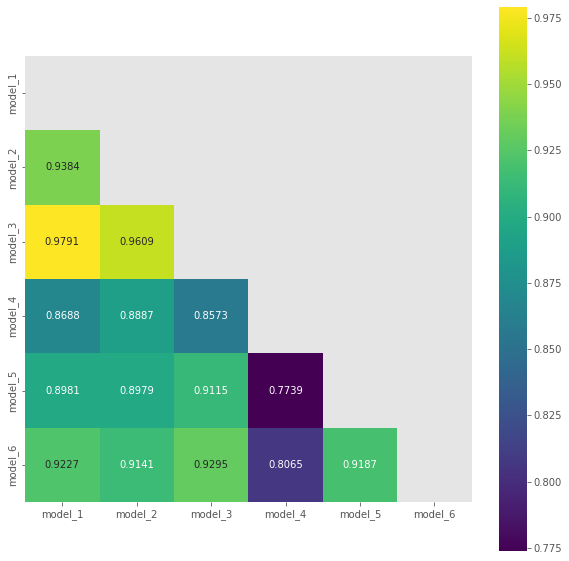

In [ ]:
corr = oof_predictions_two.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)
plt.show()

In [ ]:
test_predictions_two = pd.DataFrame({f"model_{i}": mdl for i, mdl in enumerate((model1_test_preds,
                                                                                model2_test_preds,
                                                                                model3_test_preds,
                                                                                model4_test_preds,
                                                                                tf1_total_test,
                                                                                tf2_total_test), 1)})

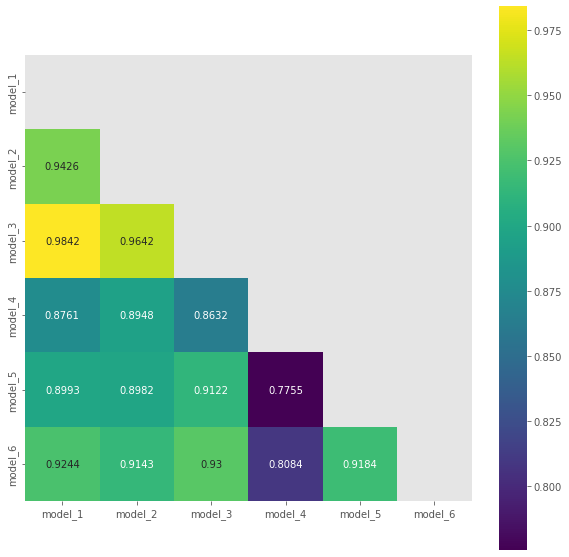

In [ ]:
corr = test_predictions_two.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)
plt.show()

In [ ]:
mean_scores(oof_predictions_two, y)

AMean score: 0.72532
GMean score: 0.72633
Rank  score: 0.72386
GMean  rank: 0.72405


In [ ]:
results_list_two = []   
weights_list_two = []  
preds_two = oof_predictions_two.values

def weights_objective(weights):
    y_ens = np.average(preds_two, axis=1, weights=weights)
    return roc_auc_score(y2, y_ens)

for _ in range(100):
  
    w0 = np.random.uniform(size=preds_two.shape[1])
    bounds = [(0,1)] * preds_two.shape[1]

    cons = [{'type': 'eq',
             'fun': lambda w: w.sum() - 1}]

    res = minimize(weights_objective,
                   w0,
                   method='SLSQP',
                   bounds=bounds,
                   options={'disp':False, 'maxiter':10000},
                   constraints=cons)

    results_list_two.append(res.fun)
    weights_list_two.append(res.x)

best_score_two = np.max(results_list_two)    
best_weights_two = weights_list_two[results_list_two.index(best_score_two)]

print('\nOptimized weights:')
print('Best score: {:.4f}'.format(best_score_two))


Optimized weights:
Best score: 0.7292


In [ ]:
optimized_scores_two = np.average(oof_predictions_two, axis=1, weights=best_weights_two)
roc_auc_score(y, optimized_scores_two)

0.7291933807172566

In [ ]:
lda2 = LinearDiscriminantAnalysis(
                                 solver='eigen',
                                 shrinkage='auto',
                                 store_covariance=True,
                                 n_components=1
                                )

lda_estimators2, _, _, _, oof_lda2 = make_modify_cross_validation(
                                                          oof_predictions_two, 
                                                          y, 
                                                          lda2, 
                                                          metric=roc_auc_score, 
                                                          cv_strategy=KFold(n_splits=10, shuffle=True, random_state=seed), 
                                                          error_to_be_outlier=False
                                                          )

Fold: 1, train-observations = 99083, valid-observations = 11010
train-score = 0.7316, valid-score = 0.7344
Fold: 2, train-observations = 99083, valid-observations = 11010
train-score = 0.7319, valid-score = 0.731
Fold: 3, train-observations = 99083, valid-observations = 11010
train-score = 0.7316, valid-score = 0.7334
Fold: 4, train-observations = 99084, valid-observations = 11009
train-score = 0.7322, valid-score = 0.7287
Fold: 5, train-observations = 99084, valid-observations = 11009
train-score = 0.7319, valid-score = 0.7308
Fold: 6, train-observations = 99084, valid-observations = 11009
train-score = 0.7317, valid-score = 0.7322
Fold: 7, train-observations = 99084, valid-observations = 11009
train-score = 0.7309, valid-score = 0.7409
Fold: 8, train-observations = 99084, valid-observations = 11009
train-score = 0.7319, valid-score = 0.7313
Fold: 9, train-observations = 99084, valid-observations = 11009
train-score = 0.7321, valid-score = 0.729
Fold: 10, train-observations = 99084, v

In [ ]:
train_lda_preds = np.array([estimator.predict_proba(oof_predictions_two)[:,1] for estimator in lda_estimators2]).T
train_lda_preds = pd.DataFrame(data=train_lda_preds)
mean_scores(train_lda_preds, y)

AMean score: 0.73186
GMean score: 0.73186
Rank  score: 0.73185
GMean  rank: 0.73185


In [ ]:
results_list_two_lda = []   
weights_list_two_lda = []  
preds_two_lda = train_lda_preds.values

def weights_objective(weights):
    y_ens = np.average(preds_two_lda, axis=1, weights=weights)
    return roc_auc_score(y, y_ens)

for _ in range(100):
  
    w0 = np.random.uniform(size=preds_two_lda.shape[1])
    bounds = [(0,1)] * preds_two_lda.shape[1]

    cons = [{'type': 'eq',
             'fun': lambda w: w.sum() - 1}]

    res = minimize(weights_objective,
                   w0,
                   method='SLSQP',
                   bounds=bounds,
                   options={'disp':False, 'maxiter':10000},
                   constraints=cons)

    results_list_two_lda.append(res.fun)
    weights_list_two_lda.append(res.x)

best_score_two_lda = np.max(results_list_two_lda)    
best_weights_two_lda = weights_list_two_lda[results_list_two_lda.index(best_score_two_lda)]

print('\nOptimized weights:')
print('Best score: {:.4f}'.format(best_score_two_lda))


Optimized weights:
Best score: 0.7319


In [ ]:
optimized_scores_two_lda = np.average(train_lda_preds, axis=1, weights=best_weights_two_lda)
roc_auc_score(y, optimized_scores_two_lda)

0.7318844305593912

In [ ]:
calculate_confidence_interval(create_bootstrap_metrics(y, optimized_scores_two_lda, roc_auc_score))

(0.7267196527865419, 0.7370103694488828)

In [ ]:
test_lda_preds = np.array([estimator.predict_proba(test_predictions_two)[:,1] for estimator in lda_estimators2]).T

In [ ]:
test_lda_preds_scores = np.average(test_lda_preds, axis=1, weights=best_weights_two_lda)

In [ ]:
final_part_two = pd.DataFrame({ID_COL: test[ID_COL], TARGET: test_lda_preds_scores})

In [ ]:
submission = test.merge(final_part_one, on=ID_COL, how='left')
submission.drop('NAME_CONTRACT_TYPE', axis=1, inplace=True)

In [ ]:
submission.loc[submission[TARGET].isna(), TARGET] = final_part_two.loc[submission[TARGET].isna(), TARGET]

In [ ]:
submission.to_csv('submission.csv', index=False)

In [ ]:
!kaggle competitions submit -c geekbrains-competitive-data-analysis -f submission.csv -m "test1"

Successfully submitted to GeekBrains Competitive Data Analysis



  0%|          | 0.00/4.91M [00:00<?, ?B/s]
  4%|4         | 216k/4.91M [00:00<00:05, 918kB/s]
 23%|##2       | 1.12M/4.91M [00:00<00:00, 4.10MB/s]
 34%|###4      | 1.69M/4.91M [00:00<00:01, 2.55MB/s]
 64%|######3   | 3.14M/4.91M [00:00<00:00, 5.21MB/s]
100%|##########| 4.91M/4.91M [00:00<00:00, 8.12MB/s]
100%|##########| 4.91M/4.91M [00:02<00:00, 2.38MB/s]


In [ ]:
# boruta
# models CV (boosting), optimization (auc -> 0.735), optuna CV (np.mean or np.min or np.std(minimize) score)
# CI
# oof preds mean_scores, weighted mean_scores, lda/log stack
# concat predictions (check first submit and compare with CI, define next steps)

In [ ]:
def profiling(df):
    
    df['DAYS_ON_LAST_JOB'].replace(365243, np.nan, inplace= True)
    df['NEW_CREDIT_TO_ANNUITY_RATIO'] = df['AMOUNT_CREDIT'] / df['AMOUNT_ANNUITY']
    df['NEW_STATUS'] = df['GENDER'] + df['FAMILY_STATUS'].astype(str)
    
    df, cat_cols = get_encoded(df, nan_as_category=False)
    
    return df

def get_encoded(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype in ['object', 'category']]
    df = pd.get_dummies(df, columns = categorical_columns, dummy_na = nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


raw_train = pd.read_csv('train.csv')
raw_cp = pd.read_csv('client_profile.csv')

train_ = raw_train.merge(raw_cp, on=ID_COL, how='left')

target_ = train_[TARGET]

train_ = train_.drop([ID_COL, TARGET], axis=1)

train_ = profiling(train_)

train_['NEW_STATUS_FUnknown'] = 0
train_['NEW_STATUS_XNACivil marriage'] = 0

In [ ]:
def lightgbm_cross_validation(params, X, y, cv, categorical=None, rounds=50):

    estimators, folds_scores, train_scores = [], [], []
    
    if not categorical:
        categorical = "auto"

    oof_preds = np.zeros(X.shape[0])
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        
        model = LGBMClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            eval_metric="auc", 
            verbose=0, 
            early_stopping_rounds=rounds
        )
        train_score = model.predict_proba(x_train)[:,1]
        train_score = roc_auc_score(y_train, train_score)
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        folds_scores.append(round(score, 5))
        train_scores.append(round(train_score, 5))
        print(f"Fold {fold + 1}, Train score = {train_score:.5f}, Valid score = {score:.5f}")
        estimators.append(model)

    print_scores(folds_scores, train_scores)
    print(f"OOF-score: {roc_auc_score(y, oof_preds):.5f}")
    return estimators, oof_preds

def catboost_cross_validation(params, X, y, cv, categorical=None, rounds=50):

    estimators, folds_scores, train_scores = [], [], []

    oof_preds = np.zeros(X.shape[0])
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        
        model = CatBoostClassifier(cat_features=categorical, **params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            early_stopping_rounds=rounds
        )
        train_score = model.predict_proba(x_train)[:,1]
        train_score = roc_auc_score(y_train, train_score)
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        folds_scores.append(round(score, 5))
        train_scores.append(round(train_score, 5))
        print(f"Fold {fold + 1}, Train score = {train_score:.5f}, Valid score = {score:.5f}")
        estimators.append(model)

    print_scores(folds_scores, train_scores)
    print(f"OOF-score: {roc_auc_score(y, oof_preds):.5f}")
    return estimators, oof_preds

def print_scores(folds_scores, train_scores):
    print(f"Train score by each fold: {train_scores}")
    print(f"Valid score by each fold: {folds_scores}")
    print(f"Train mean score by each fold:{np.mean(train_scores):.5f} +/- {np.std(train_scores):.5f}")
    print(f"Valid mean score by each fold:{np.mean(folds_scores):.5f} +/- {np.std(folds_scores):.5f}")
    print("*" * 50)

In [ ]:
lgbm_params_ = {
    'metric':"auc", 
    'boosting_type': 'gbdt',
    'n_estimators': 1000,
    'learning_rate': 0.03,
    'num_leaves': 42,
    'max_depth': 10,
    'reg_alpha': 0.05,
    'reg_lambda': 0.06,
    'subsample': 0.8,
    'min_child_weight': 60,
    'random_state': seed
}
cv_strategy = KFold(n_splits=5, random_state=seed, shuffle=True)

estimators_lgbm, oof_preds_lgbm = lightgbm_cross_validation(lgbm_params_, train_, target_, cv=cv_strategy)

Thu Aug 25 11:19:40 2022, Cross-Validation, 110093 rows, 51 cols
Fold 1, Train score = 0.78336, Valid score = 0.74392
Fold 2, Train score = 0.78505, Valid score = 0.72345
Fold 3, Train score = 0.77757, Valid score = 0.73236
Fold 4, Train score = 0.78079, Valid score = 0.73205
Fold 5, Train score = 0.79660, Valid score = 0.71923
Train score by each fold: [0.78336, 0.78505, 0.77757, 0.78079, 0.7966]
Valid score by each fold: [0.74392, 0.72345, 0.73236, 0.73205, 0.71923]
Train mean score by each fold:0.78467
Valid mean score by each fold:0.73020
**************************************************
OOF-score: 0.72913


In [ ]:
roc_auc_score(target_, oof_preds_lgbm)

0.7291312037068914

In [ ]:
def bki_cr(num_rows = None, nan_as_category = True):
    bureau = pd.read_csv('bki.csv', nrows = num_rows)
    bureau, bureau_cat = get_encoded(bureau, nan_as_category)

    bureau.drop(['BUREAU_ID'], axis=1, inplace= True)
    
    num_aggregations = {
        'CREDIT_DAY_OVERDUE': ['mean'],
        'AMT_CREDIT_MAX_OVERDUE': ['mean'],
        'AMT_CREDIT_SUM_OVERDUE': ['mean']
    }
    cat_aggregations = {}
    for cat in bureau_cat: cat_aggregations[cat] = ['mean']
    
    bureau_agg = bureau.groupby(ID_COL).agg({**num_aggregations, **cat_aggregations})
    bureau_agg.columns = pd.Index(['BURO_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])
    
    active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
    active_agg = active.groupby(ID_COL).agg(num_aggregations)
    active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(active_agg, how='left', on=ID_COL)

    closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
    closed_agg = closed.groupby(ID_COL).agg(num_aggregations)
    closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
    bureau_agg = bureau_agg.join(closed_agg, how='left', on=ID_COL)

    return bureau_agg
def get_encoded(df, nan_as_category = True):
    original_columns = list(df.columns)
    categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns = categorical_columns, dummy_na = nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns

In [ ]:
def prepare_bki_sec() -> pd.DataFrame:
    df = pd.read_csv('bki.csv')
    df.drop('BUREAU_ID', axis=1, inplace=True)
    # fill nans with zeros
    df.fillna(0, inplace=True)

    # large values 
    df['susp'] = 0
    
    sharp_columns = {column: df[column].kurtosis() for column in df.select_dtypes(include="number").columns}
    for column, value in sharp_columns.items():
        if np.abs(value) > 10:
            condition = ((df[column] < np.percentile(df[column], 1)) | (df[column] > np.percentile(df[column], 99)))
            df.loc[condition, 'susp'] = 1
            # p1 = np.percentile(df[column], 1)
            # p2 = np.percentile(df[column], 99)
            # df[column] = np.clip(df[column], p1, p2)
    
    # create new features: mean and sum of AMTs grouped by credit-type
    amount_cols = [col for col in df.columns if col.startswith('AMT')]
    for i, column in enumerate(amount_cols, 1):
        df[f"{column}_CREDIT_TYPE"] = df.groupby('CREDIT_TYPE')[column].transform("mean")
    
    df['AMT_SUM'] = df[amount_cols].sum(axis=1)
    df['AMT_KUR'] = df[amount_cols].kurtosis(axis=1)

    # reduce dataset size
    df = df[df[ID_COL].isin(list(train_ids | test_ids))]

    # mean and sum 
    agg_funcs = dict(zip(amount_cols, [["mean", "sum"]]*len(amount_cols)))
    mask = df['CREDIT_ACTIVE'] == 'Active'
    active_agg = create_numerical_aggs(data=df[mask], groupby_id=ID_COL, aggs=agg_funcs, suffix="_BY_CREDIT_ACTIVE").fillna(0)

    mask = df['CREDIT_ACTIVE'] == 'Closed'
    inactive_agg = create_numerical_aggs(data=df[mask], groupby_id=ID_COL, aggs=agg_funcs, suffix="_BY_CREDIT_INACTIVE").fillna(0)

    # aggregate by ID_COL with different statistics to preserve individual loans info
    agg_funcs = {column: ["mean", "count", "min", "max", "std", "sum"] for column in df.select_dtypes(exclude="object").columns[1:]}
    num_df = create_numerical_aggs(data=df.select_dtypes(exclude="object"), groupby_id=ID_COL, aggs=agg_funcs).fillna(0)

    cat_df = create_categorical_aggs(data=df, groupby_id=ID_COL, features=['CREDIT_CURRENCY', 'CREDIT_TYPE']).fillna(0)

    df = pd.merge(num_df, cat_df, on=ID_COL, how='left')
    # df = pd.merge(df, num_cat, on=ID_COL, how='left')
    df = df.merge(active_agg, how='left', on=ID_COL)
    df= df.merge(inactive_agg, on=ID_COL, how='left')
    del cat_df, num_df, active_agg, inactive_agg

    df.fillna(0, inplace=True)
    # reduce memory usage
    df = reduce_memory_df(df)

    return df
select = [sel for sel in selected if not sel.startswith('NAME')]
bki_fin = prepare_bki_sec()[select + [ID_COL]]
bki_fin_train = bki_fin[bki_fin[ID_COL].isin(train_ids)]
bki_fin_test = bki_fin[bki_fin[ID_COL].isin(test_ids)]